In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append('./../src/')
from manuscript import sankey_side_by_side as sankey
from manuscript import clustering, datasets, inout, export

pd.options.display.max_columns = 200
mpl.rcParams["figure.figsize"] = (10, 8)
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["font.family"] = "Arial"

import IPython.display
IPython.display.display(IPython.display.HTML("<style>.container { width:90% !important; }</style>"))

fonts = inout.get_resource_path('fonts')
for f in os.listdir(fonts):
    if f.endswith(".ttf"):
        mpl.font_manager.fontManager.addfont(f"{fonts}/{f}")

In [3]:
user = 'general'     # defines top hierarchy of output folder
outfolder = '04_clustering'    # name of notebook
save = True

In [4]:
def dump_figure(name):
    if save:
        export.image(
            user,
            f'{outfolder}/{name}',
        )

In [5]:
def dump_table(df, name):
    if save:
        export.full_frame(
            user, 
            f'{outfolder}/{name}', 
            df, 
            index=True,
            date=True
        )

# Get Data, as in reference

In [6]:
data = pd.read_csv(
    inout.get_material_path('general/03_overwrite_PF_Cr/03data-external_220920_1613.csv.gz'), 
    index_col=0)

In [7]:
data.shape

(12495, 72)

In [8]:
data = data.reset_index()

List of columns for clustering

In [9]:
data_columns = clustering.get_reference_data_columns()

Get data that we will run clustering on

In [10]:
data_mtx_orig = data[data_columns].copy()

## 0. Preparation of shared aspects

Let's create groups of variables which share those high correlations. Let's try different cutoffs for high correlation, as they produce different results

In [11]:
cutoff_groups_on_orig = clustering.identify_related_features(data_mtx_orig)


In [12]:
data_mtx_as_pct = data_mtx_orig.rank(axis=0, pct=True)
data_dist_col = clustering.get_distances(
    data_mtx_as_pct.transpose(), approach='nan_euclidean')   
col_tree = clustering.get_tree(data_dist_col, approach='ward')

In [13]:
threshold_for_relatedness = 0.7
cutoff_groups = cutoff_groups_on_orig[threshold_for_relatedness]

In [14]:
approaches = {}

## 1. Similarity approach

In [15]:
data_mtx = data_mtx_orig.copy()
data_mtx = data_mtx.rank(axis=0, pct=True)

data_mtx_for_similarity = data_mtx.copy()
data_mtx_for_similarity = clustering.reweight_related_features(
    data_mtx_for_similarity, 
    approach='mean_rank', 
    groups=cutoff_groups)

In [16]:
corr_mtx = data_mtx_for_similarity.transpose().corr("pearson")
data_dist = clustering.get_distances(corr_mtx, approach='euclidean')   
tree = clustering.get_tree(df_dist=data_dist, approach='ward')

In [17]:
out, assignments = clustering.table_with_assignments(
    tree=tree,
    labels=data.index
)

In [18]:
sign_mortality_similarity = clustering.get_sign_mortalities(
    df_assigned_clusters=out,
    df_with_mortality=data
)
sign_mortality_similarity.loc[:, 'approach'] = 'similarity'

In [19]:
approaches = {
    'Similarity' : {
        'feature_matrix': data_mtx,   # data_mtx_orig.rank(axis=0, pct=True),
        'data_dist':data_dist,
        'tree':tree,
        'assignments_table':out,
        'assignments':assignments
    }
}

## 2. Rank-euclidean approach

In [20]:
data_mtx = data_mtx_orig.copy()
data_mtx = data_mtx.rank(axis=0, pct=True)

data_mtx = data_mtx.copy()
data_mtx = clustering.reweight_related_features(
    data_mtx, 
    approach='square_root', 
    groups=cutoff_groups)

In [21]:
rank_data_dist = clustering.get_distances(data_mtx, approach='nan_euclidean')
rank_tree = clustering.get_tree(rank_data_dist, approach='ward')
rank_out, rank_assignments = clustering.table_with_assignments(
    tree=rank_tree,
    labels=data.index
)

sign_mortality_rank = clustering.get_sign_mortalities(
    df_assigned_clusters=rank_out, 
    df_with_mortality=data)
sign_mortality_rank.loc[:, 'approach'] = 'rank-euclidean'

In [22]:
approaches['Ranked-Euclidean'] = {
        'feature_matrix':data_mtx,
        'data_dist':rank_data_dist,
        'tree':rank_tree,
        'assignments_table':rank_out,
        'assignments':rank_assignments
}

## 3. Normalized-euclidean approach 

In [23]:
data_mtx = data_mtx_orig.copy()

In [24]:
to_winsor_both = [
    'Temperature', 'Heart_rate', 'Systolic_blood_pressure',
    'Diastolic_blood_pressure', 'Mean_arterial_pressure',
    'Respiratory_rate', 'PEEP', 'Plateau_Pressure',
    'ABG_pH', 'ABG_PaCO2', 'ABG_PaO2', 'PaO2FIO2_ratio',
    'Hemoglobin', 'Bicarbonate', 'Albumin', 'LDH',
    'Lactic_acid'
]
to_winsor_right = [
    'Norepinephrine_rate', 'Urine_output',
    'Lung_Compliance', 'WBC_count', 'Lymphocytes',
    'Neutrophils', 'Platelets', 'Creatinine',
    'Bilirubin', 'CRP', 'D_dimer', 'Ferritin',
    'Procalcitonin'
]
to_winsor_left = [
    'Oxygen_saturation'
]


WINSOR_THRESHOLD_PCT = 1

for column in data_columns:
    col = data_mtx[column].dropna()
    lower = np.percentile(col, WINSOR_THRESHOLD_PCT)
    upper = np.percentile(col, 100 - WINSOR_THRESHOLD_PCT)
    if column in to_winsor_both or column in to_winsor_left:
        data_mtx.loc[data_mtx[column] < lower, column] = lower
    if column in to_winsor_both or column in to_winsor_right:
        data_mtx.loc[data_mtx[column] > upper, column] = upper
        
    

to_log2 = [
    'Norepinephrine_rate', 'ABG_PaO2', 
    'Creatinine', 'Bilirubin', 'D_dimer', 
    'Ferritin', 'LDH', 'Lactic_acid',
    'Procalcitonin'
]

for c in to_log2:
    data_mtx[c] = np.log2(data_mtx[c])

to_quantize = [
    'ECMO_flag', 'Intubation_flag', 'Hemodialysis_flag', 'CRRT_flag',
    'Norepinephrine_flag',
    'GCS_eye_opening', 'GCS_motor_response',
    'GCS_verbal_response', 'RASS_score', 'PEEP', 'FiO2',
    'PEEP_changes', 'Respiratory_rate_changes',
    'FiO2_changes'
]

for c in to_quantize:
    data_mtx[c] = data_mtx[c].rank(pct=True)

for c in list(set(data_columns) - set(to_quantize)):
    col = data_mtx[c]
    col = (col - np.nanmin(col)) / (np.nanmax(col) - np.nanmin(col))
    data_mtx[c] = col

In [25]:
data_mtx = clustering.reweight_related_features(
    data_mtx, 
    approach='square_root', 
    groups=cutoff_groups)



In [26]:
norm_data_dist = clustering.get_distances(data_mtx, approach='nan_euclidean')
norm_tree = clustering.get_tree(norm_data_dist, approach='ward')
norm_out, norm_assignments = clustering.table_with_assignments(
    tree=norm_tree,
    labels=data.index
)

In [27]:
sign_mortality_norm = clustering.get_sign_mortalities(
    df_assigned_clusters=norm_out, 
    df_with_mortality=data)
sign_mortality_norm.loc[:, 'approach'] = 'norm-euclidean'

In [28]:
approaches['Normalized-Euclidean']  = {
        'feature_matrix':data_mtx,
        'data_dist':norm_data_dist,
        'tree':norm_tree,
        'assignments_table':norm_out,
        'assignments':norm_assignments
    }

# 3. Compare inter-cluster mortality differentiation across approaches

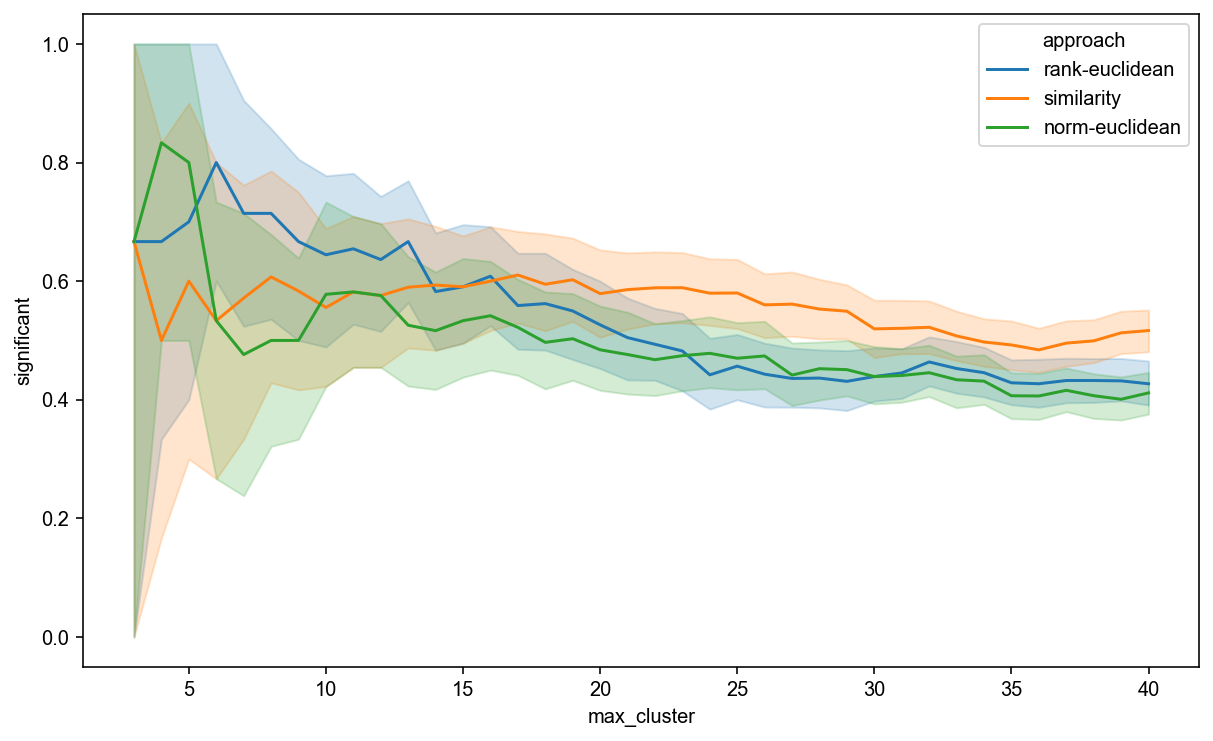

In [29]:
mpl.rcParams["figure.figsize"] = (10, 6)
sns.lineplot(
    x='max_cluster',
    y='significant',
    data=pd.concat(
        [
            sign_mortality_rank,
            sign_mortality_similarity,
            sign_mortality_norm
            
        ]).reset_index(drop=True),
    hue='approach'
)
dump_figure('approaches_significance.pdf')

### Different approaches heatmaps

In [30]:
key = 'Similarity'

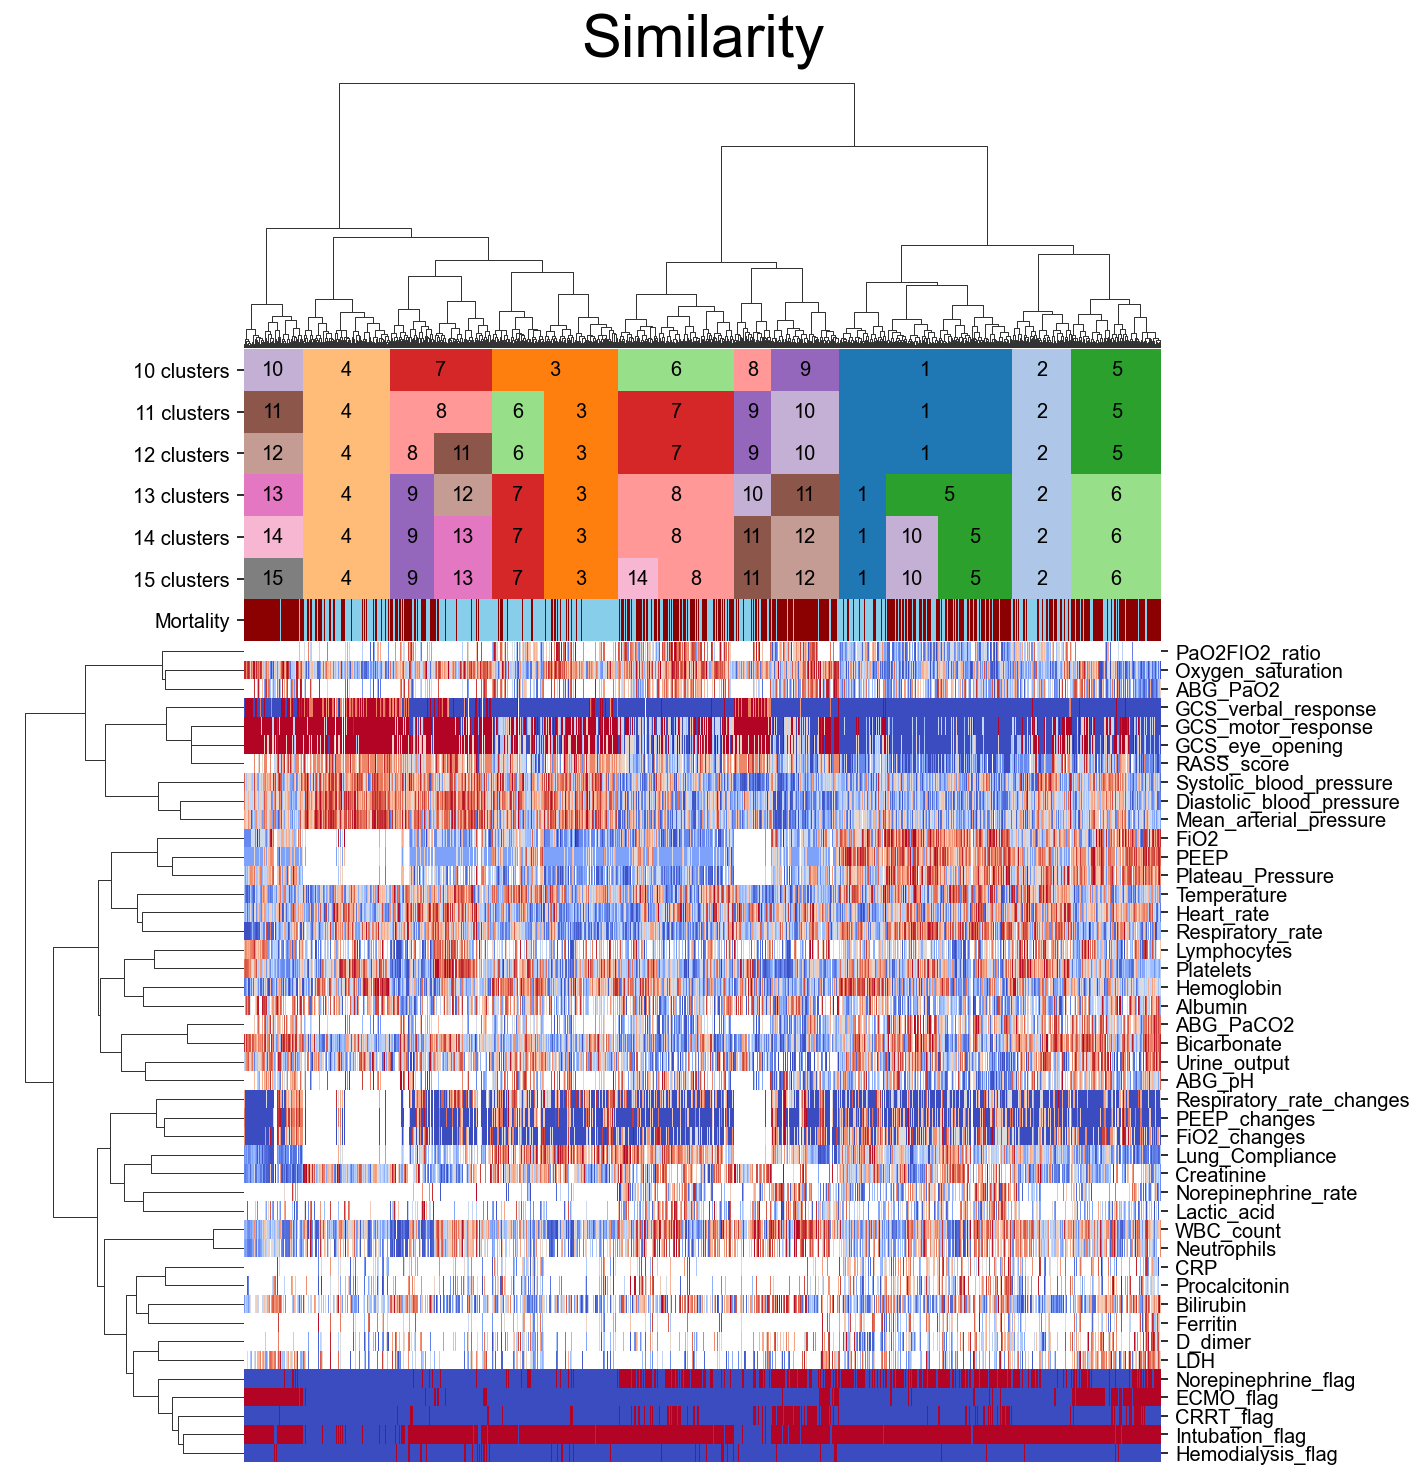

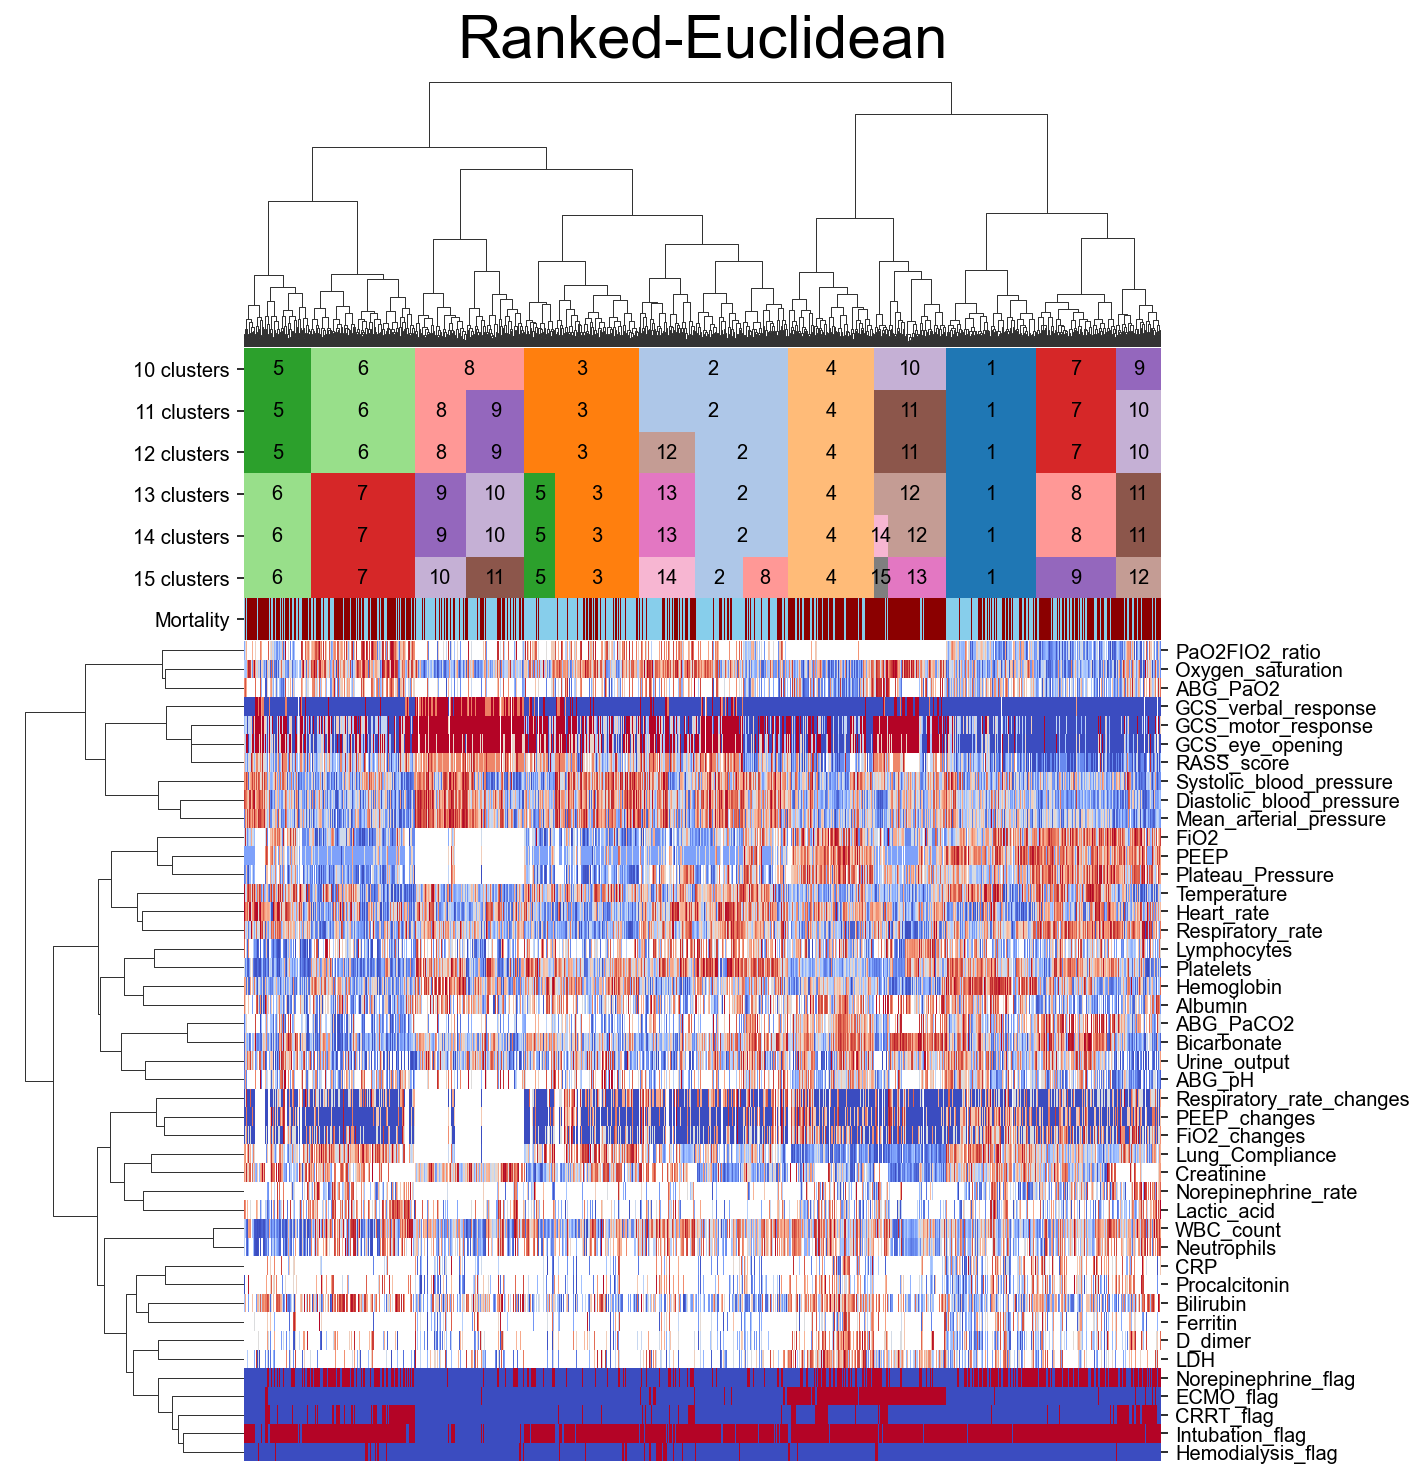

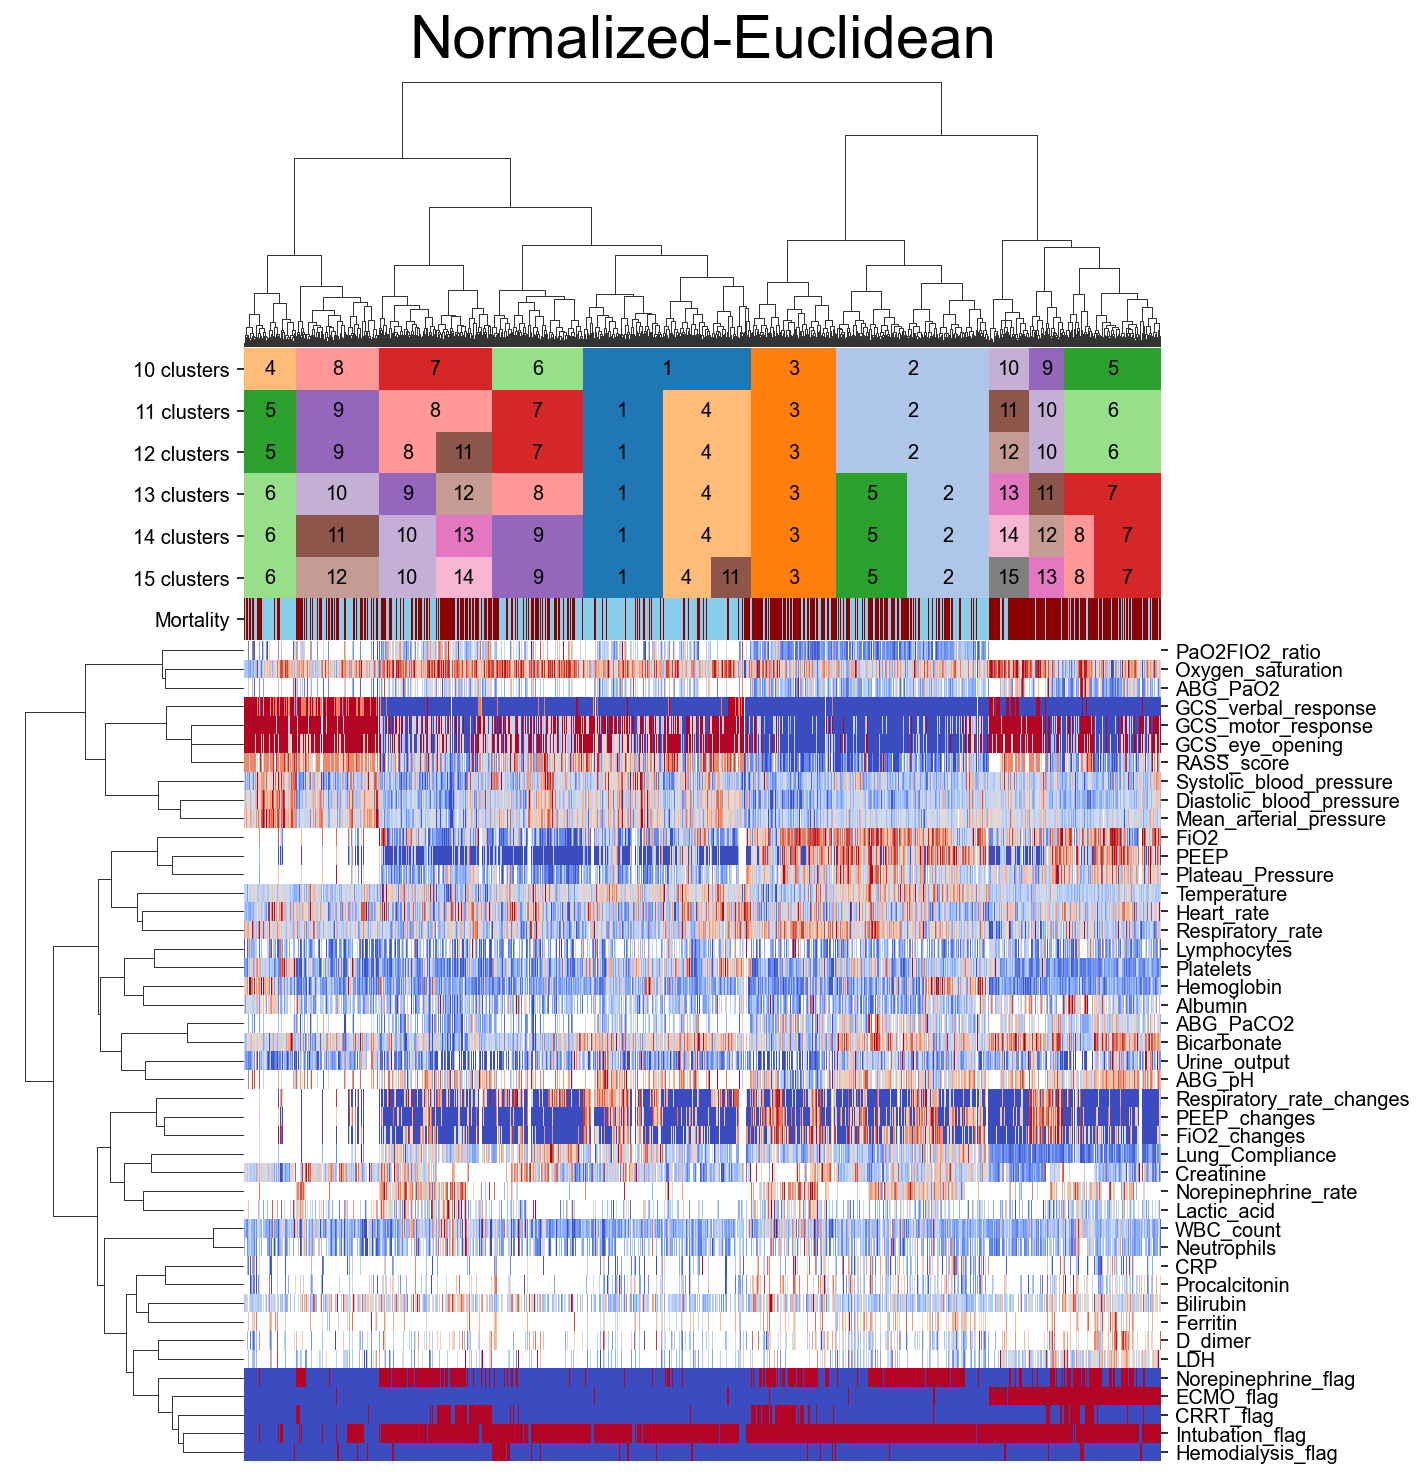

In [31]:
mpl.rcParams["figure.figsize"] = (10, 8)

for key in approaches.keys():

    clustering.heatmap(
        df_assigned_clusters=approaches[key]['assignments_table'], 
        df_with_mortality=data, 
        data_mtx=approaches[key]['feature_matrix'], 
        tree=approaches[key]['tree'], 
        col_tree=col_tree)
    plt.title(f'{key}\n\n\n\n\n\n\n\n\n', fontsize=30, loc='center')

    dump_figure(
        f'heatmap-{key}.pdf')

## 4. UMAP for best approach

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/pynndescent/pynndescent_.py:906: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  warn(
/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/pynndescent/pynndescent_.py:906: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  warn(
/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transfo

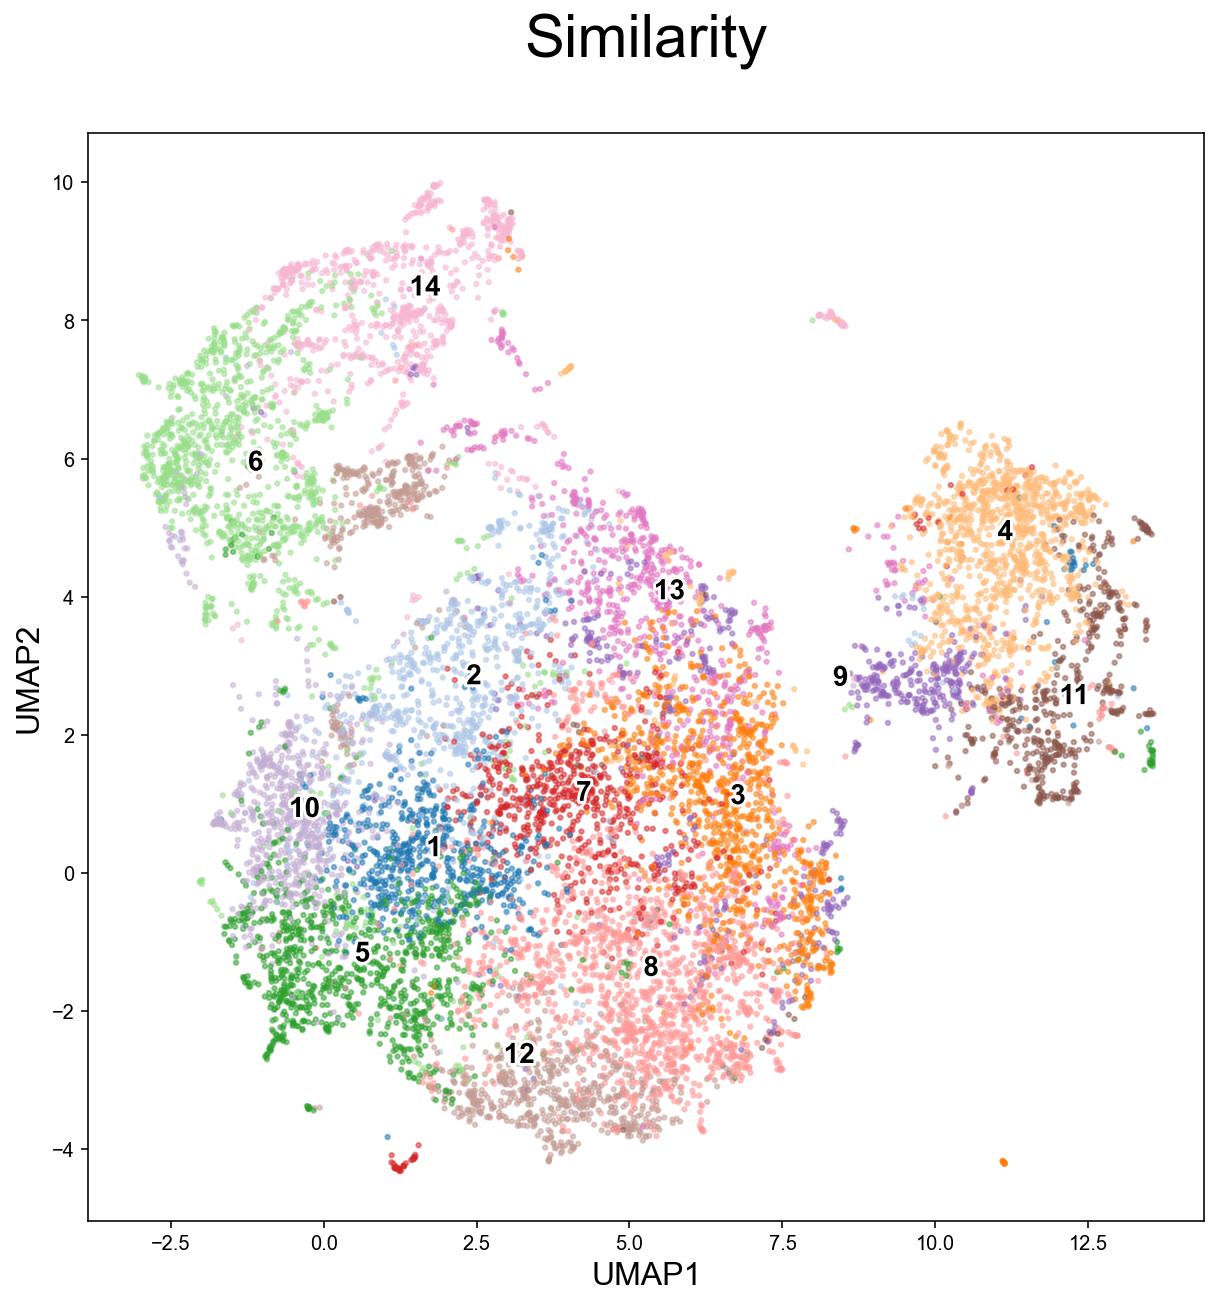

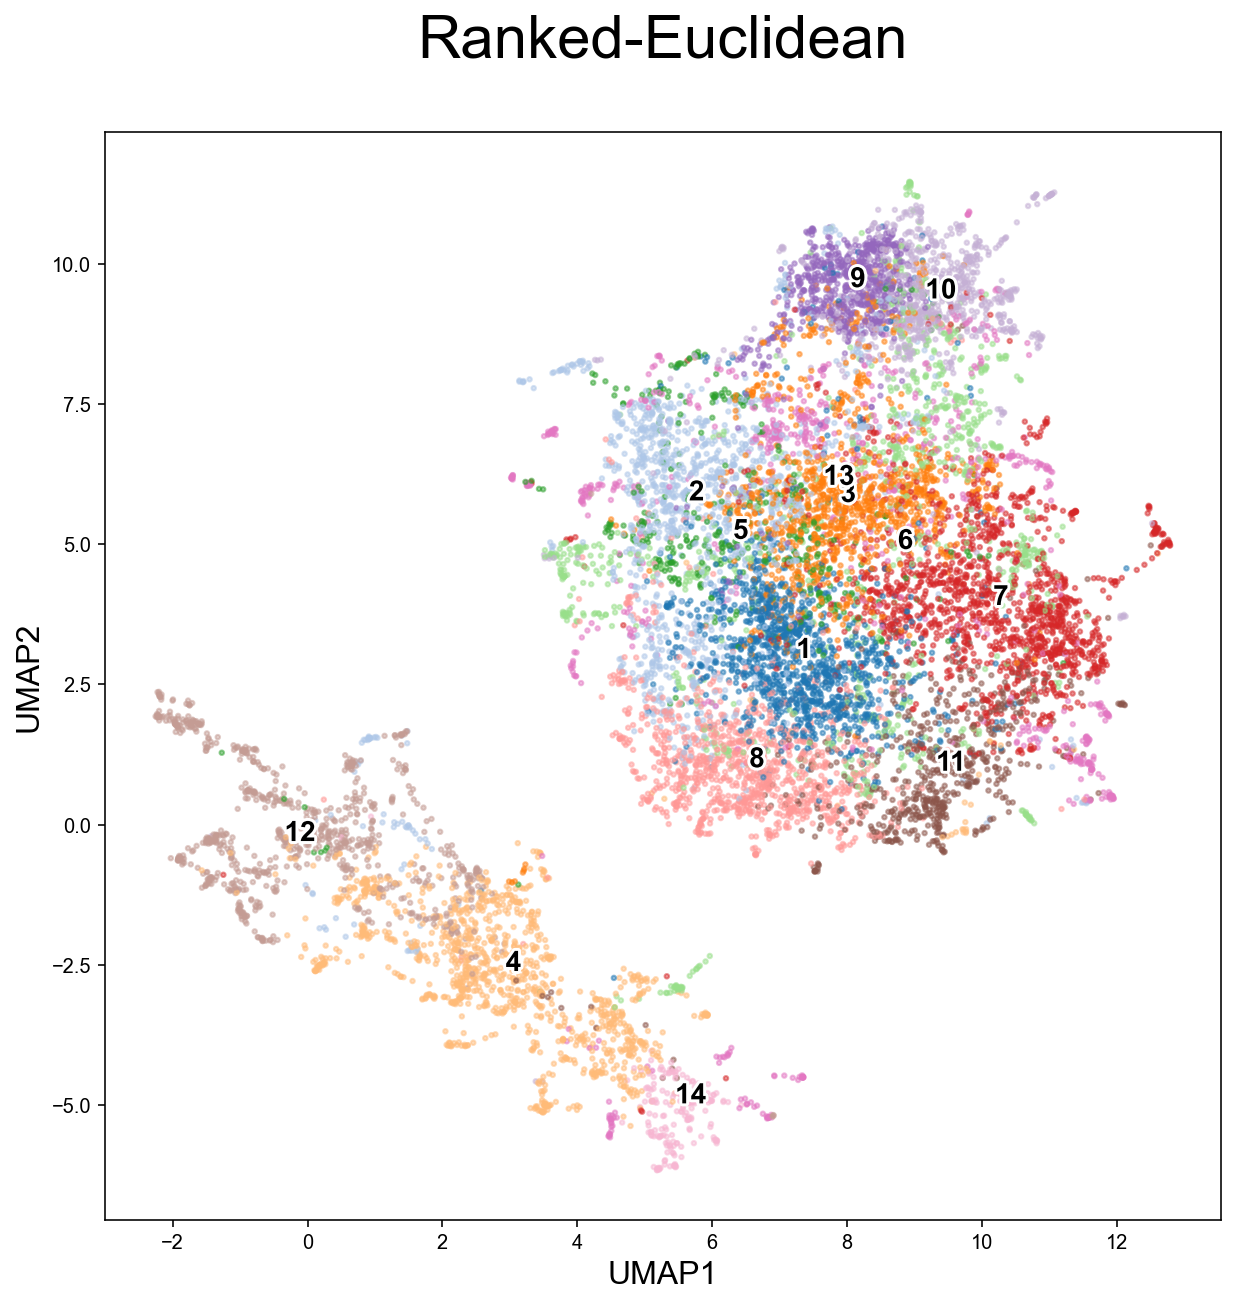

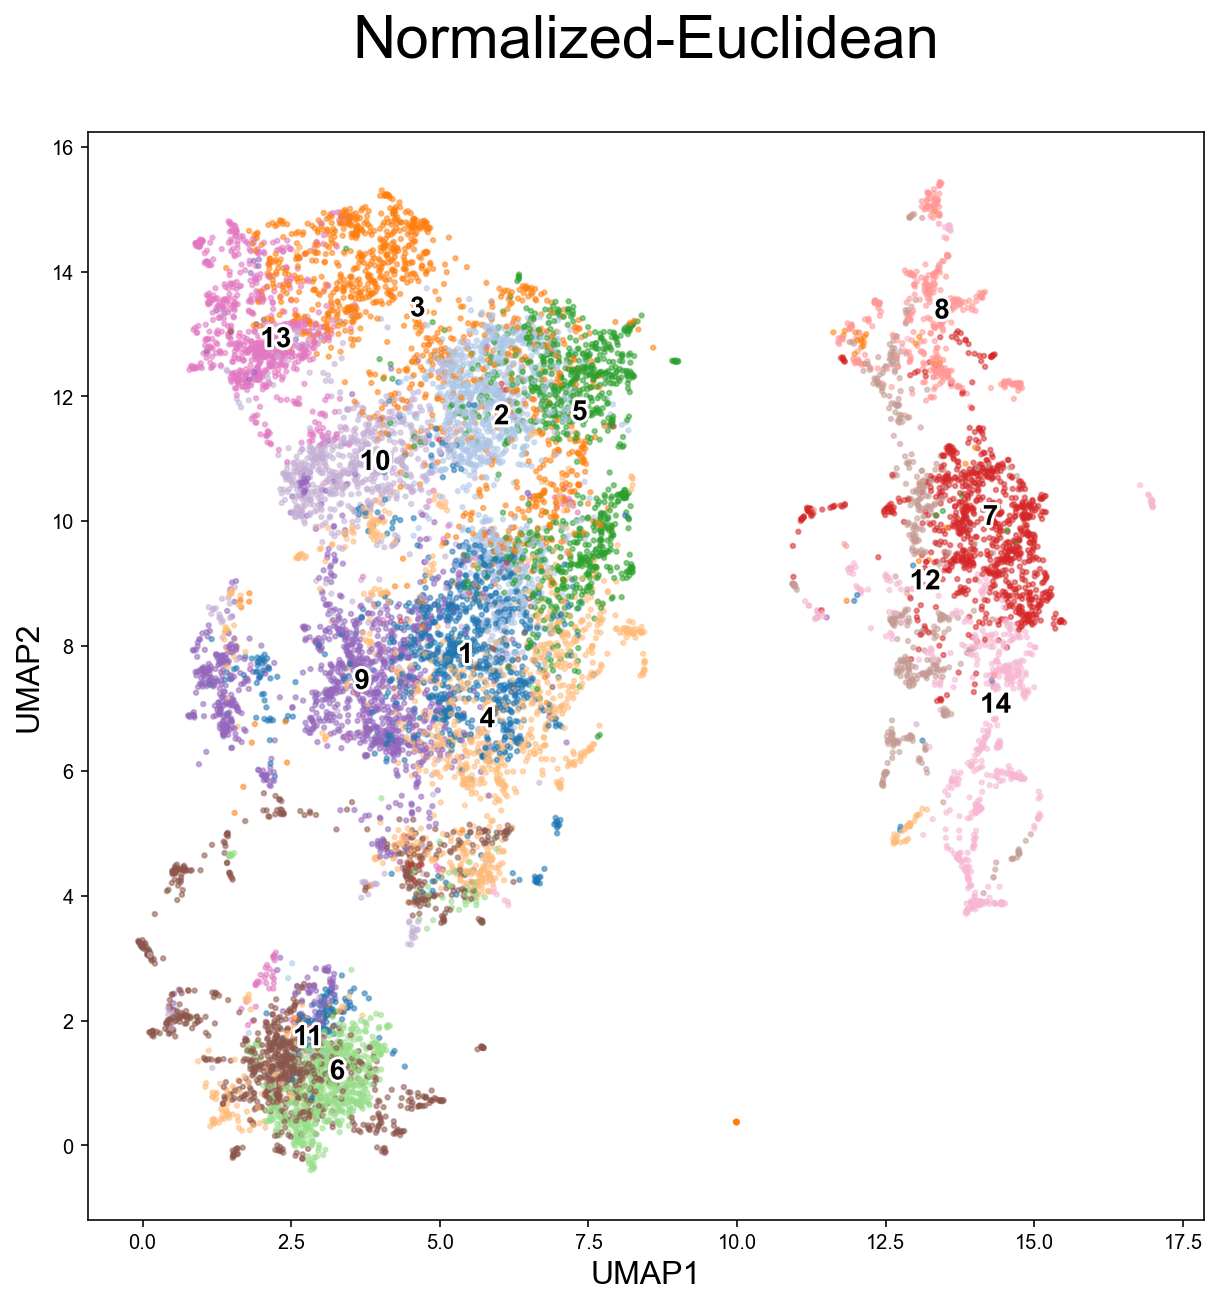

In [32]:
for key in approaches.keys():
    umap_data = clustering.show_umap(
    data=approaches[key]['data_dist'],
    assignment = approaches[key]['assignments'][14] )

    plt.title(f'{key}\n', fontsize=30, loc='center')
    
    #save umaps
    data["umap1"] = umap_data[:, 0]
    data["umap2"] = umap_data[:, 1]
    data = clustering.index_by_patient_ids_icu_stay_day(data)
    dump_table(data, f'{key}-umap.csv.gz')
    
    dump_figure(
        f'umap-{key}.pdf')

## Manually order the heatmaps on 14 clusters

In [33]:
data.drop(columns=['umap1', 'umap2'], inplace=True)
data=data.reset_index()

index  Total  Died  mortality
cluster                               
6.0          0    204    45   0.220588
12.0         1    135    30   0.222222
2.0          2    226    57   0.252212
3.0          3    352   100   0.284091
0.0          4    208    76   0.365385
1.0          5    122    47   0.385246
7.0          6    333   146   0.438438
8.0          7    106    51   0.481132
10.0         8    126    69   0.547619
4.0          9    247   159   0.643725
5.0         10     98    64   0.653061
13.0        11     30    20   0.666667
9.0         12    115    77   0.669565
11.0        13    164   110   0.670732

index  Total  Died  mortality
cluster                               
4.0          0    116    18   0.155172
8.0          1    243    67   0.275720
2.0          2    263    77   0.292776
1.0          3    185    57   0.308108
12.0         4    115    43   0.373913
0.0          5    301   115   0.382060
9.0          6    192    88   0.458333
6.0          7    272   134   0.492647
5.0          8    145    91   0.627586
7.0          9    175   113   0.645714
13.0        10      6     4   0.666667
3.0         11     56    38   0.678571
10.0        12    146   108   0.739726
11.0        13     20    16   0.800000

index  Total  Died  mortality
cluster                               
5.0          0    222    55   0.247748
0.0          1    305    83   0.272131
3.0          2    192    62   0.322917
10.0         3    271   103   0.380074
8.0          4    236    92   0.389831
1.0          5    266   105   0.394737
9.0          6    261   124   0.475096
4.0          7    154    78   0.506494
13.0         8     22    13   0.590909
12.0         9    118    72   0.610169
2.0         10    238   152   0.638655
6.0         11     45    31   0.688889
11.0        12     39    28   0.717949
7.0         13     20    15   0.750000

CPU times: user 9.05 s, sys: 942 ms, total: 10 s
Wall time: 10.6 s


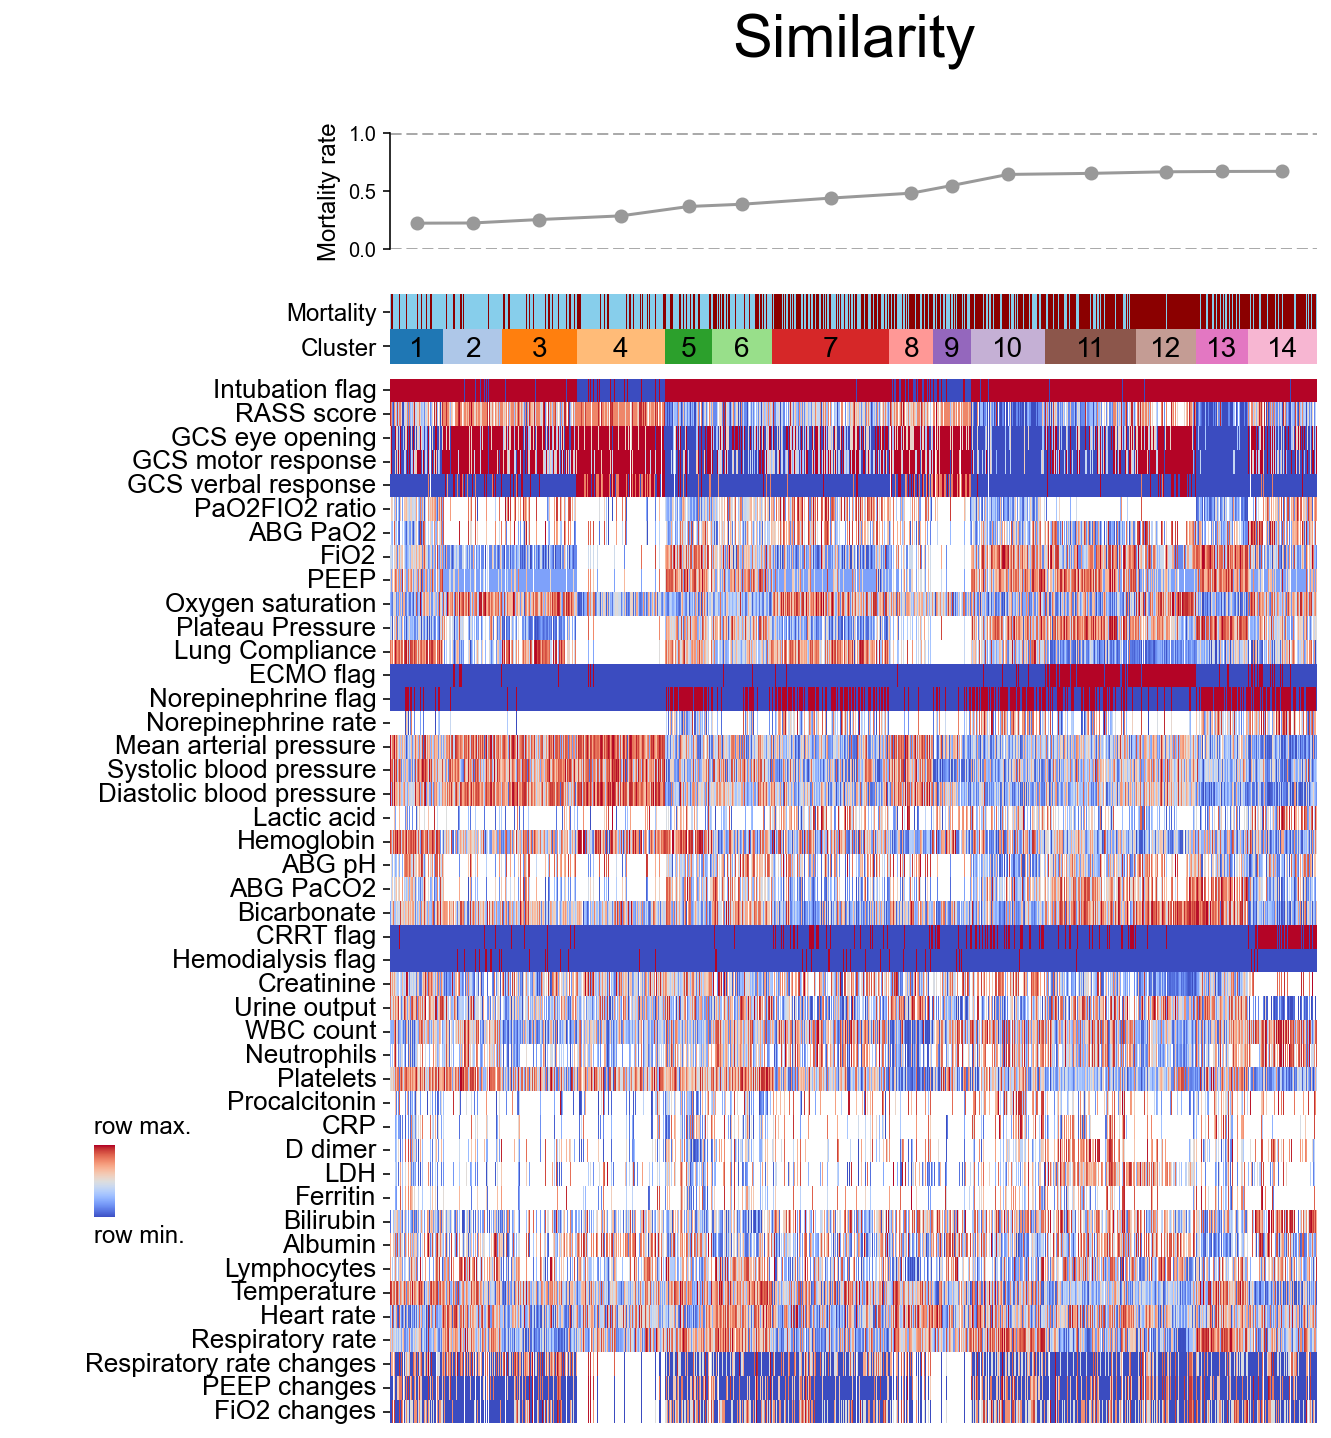

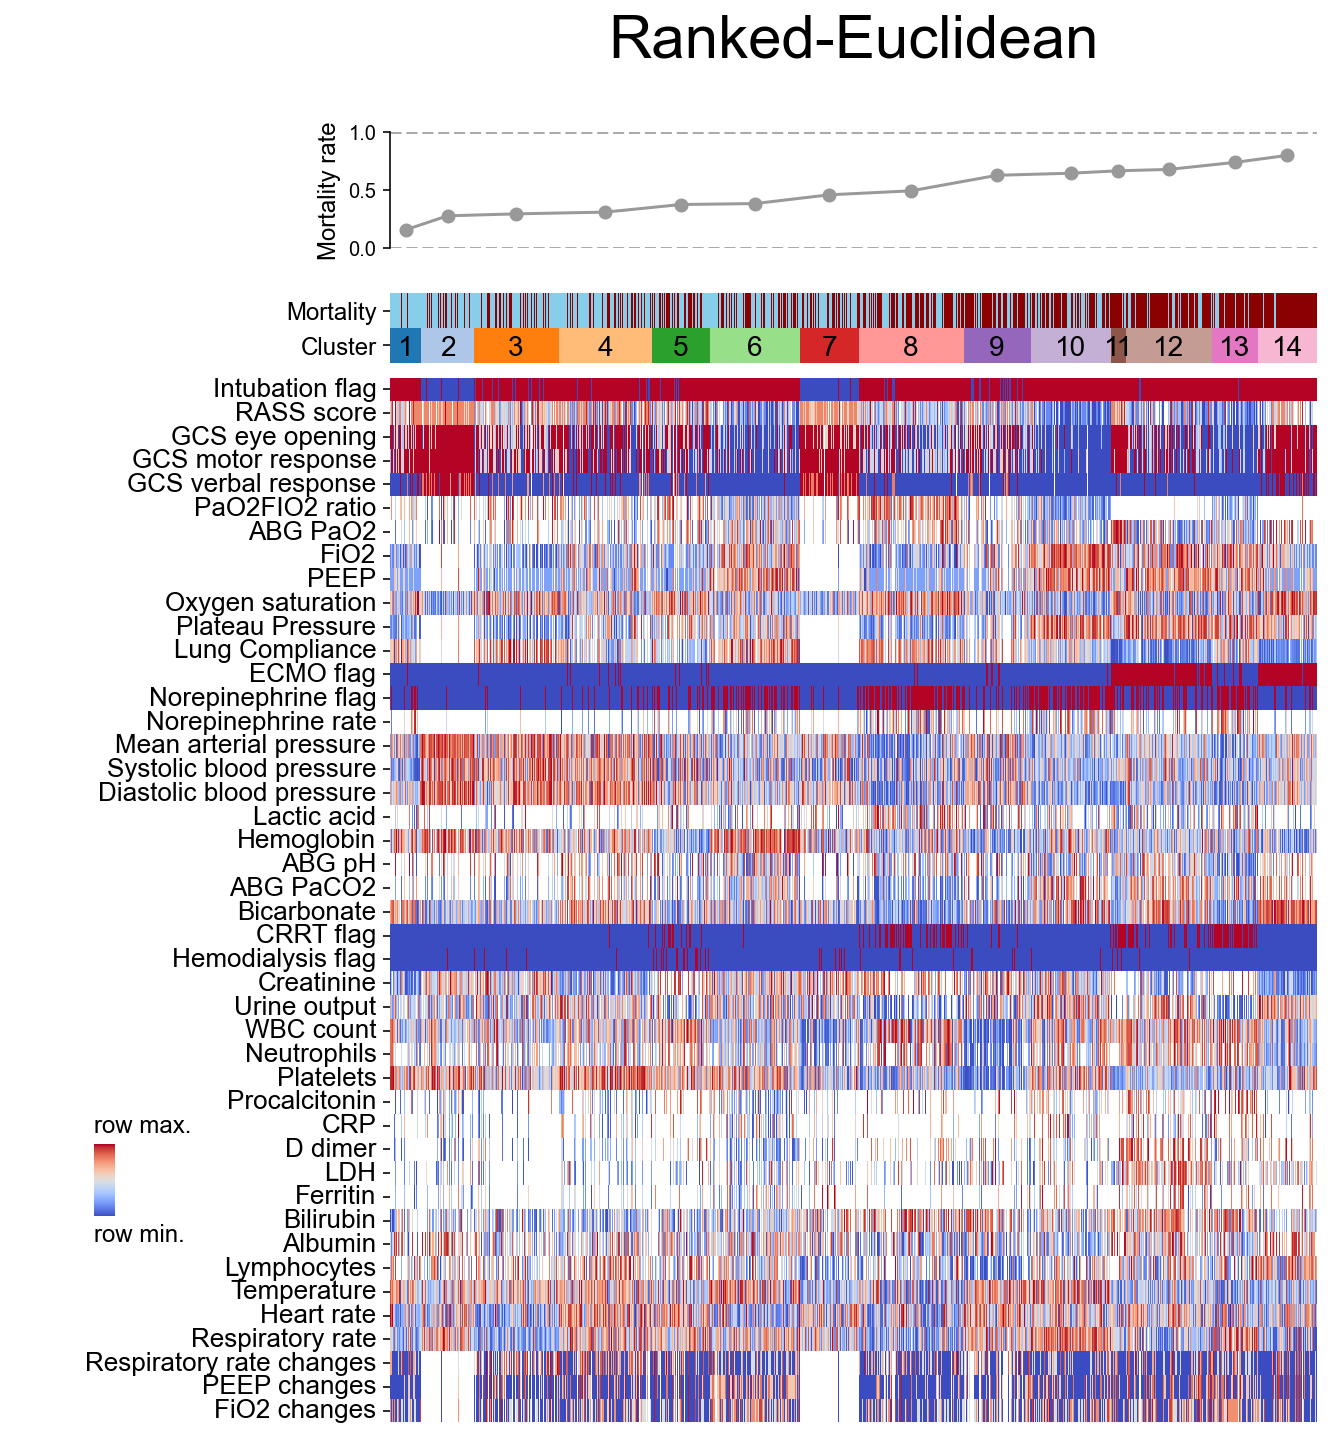

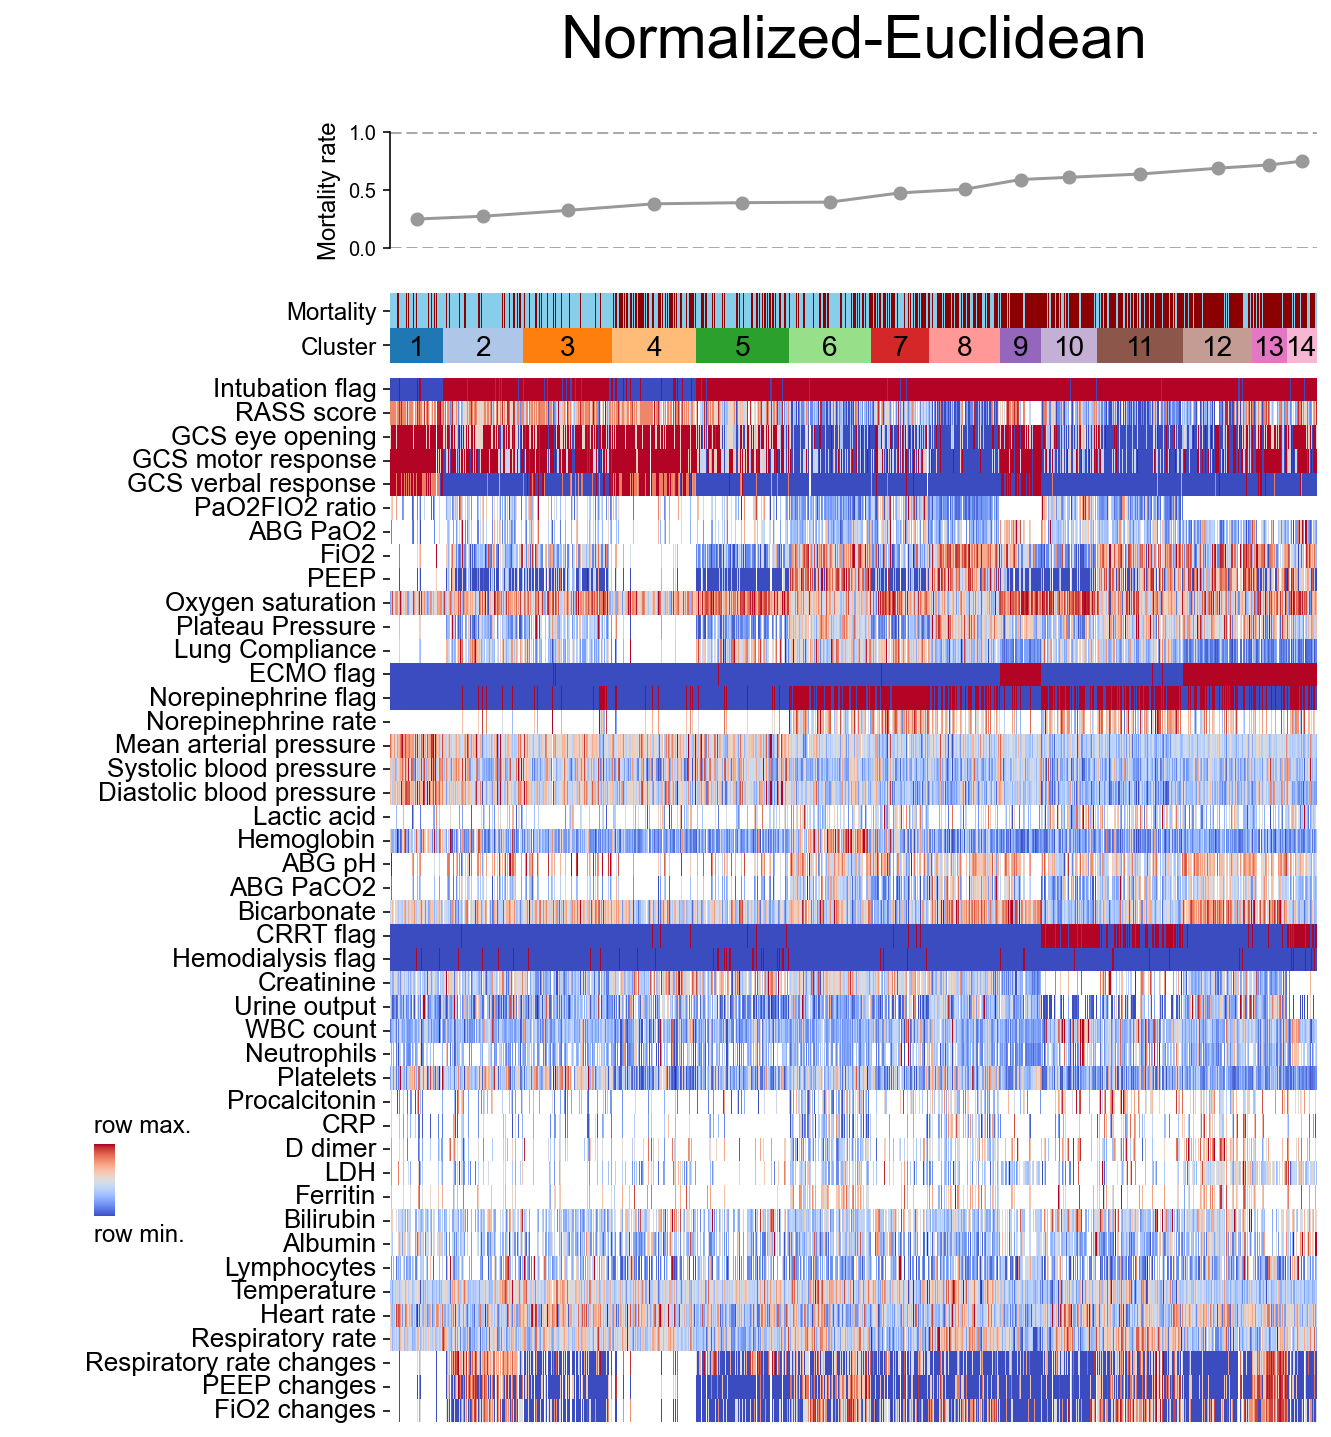

In [34]:
%%time    


for key in approaches.keys():
    
    clustering.heatmap_by_mortality(
    data_with_mortality=data,
    data_mtx=approaches[key]['feature_matrix'],
    assignment=approaches[key]['assignments'][14]
        )
    
    plt.title(f'{key}\n', fontsize=30, loc='center')
        
    dump_figure(
    f'manual_order-{key}.pdf')
    


In [35]:
#save clusters and cluster mortality

for key in approaches.keys():  
    df_with_clusters, cluster_mortality = clustering.infer_clustermortality_and_add_cluster_id(
            data_with_mortality=data,
            data_mtx=approaches[key]['feature_matrix'],
            assignment=approaches[key]['assignments'][14]
            )
    dump_table(df_with_clusters, f'{key}-clusters.csv.gz')
    dump_table(cluster_mortality, f'{key}-cluster_mortality.csv.gz')

## Quilts 

CPU times: user 3.58 s, sys: 352 ms, total: 3.93 s
Wall time: 7.36 s


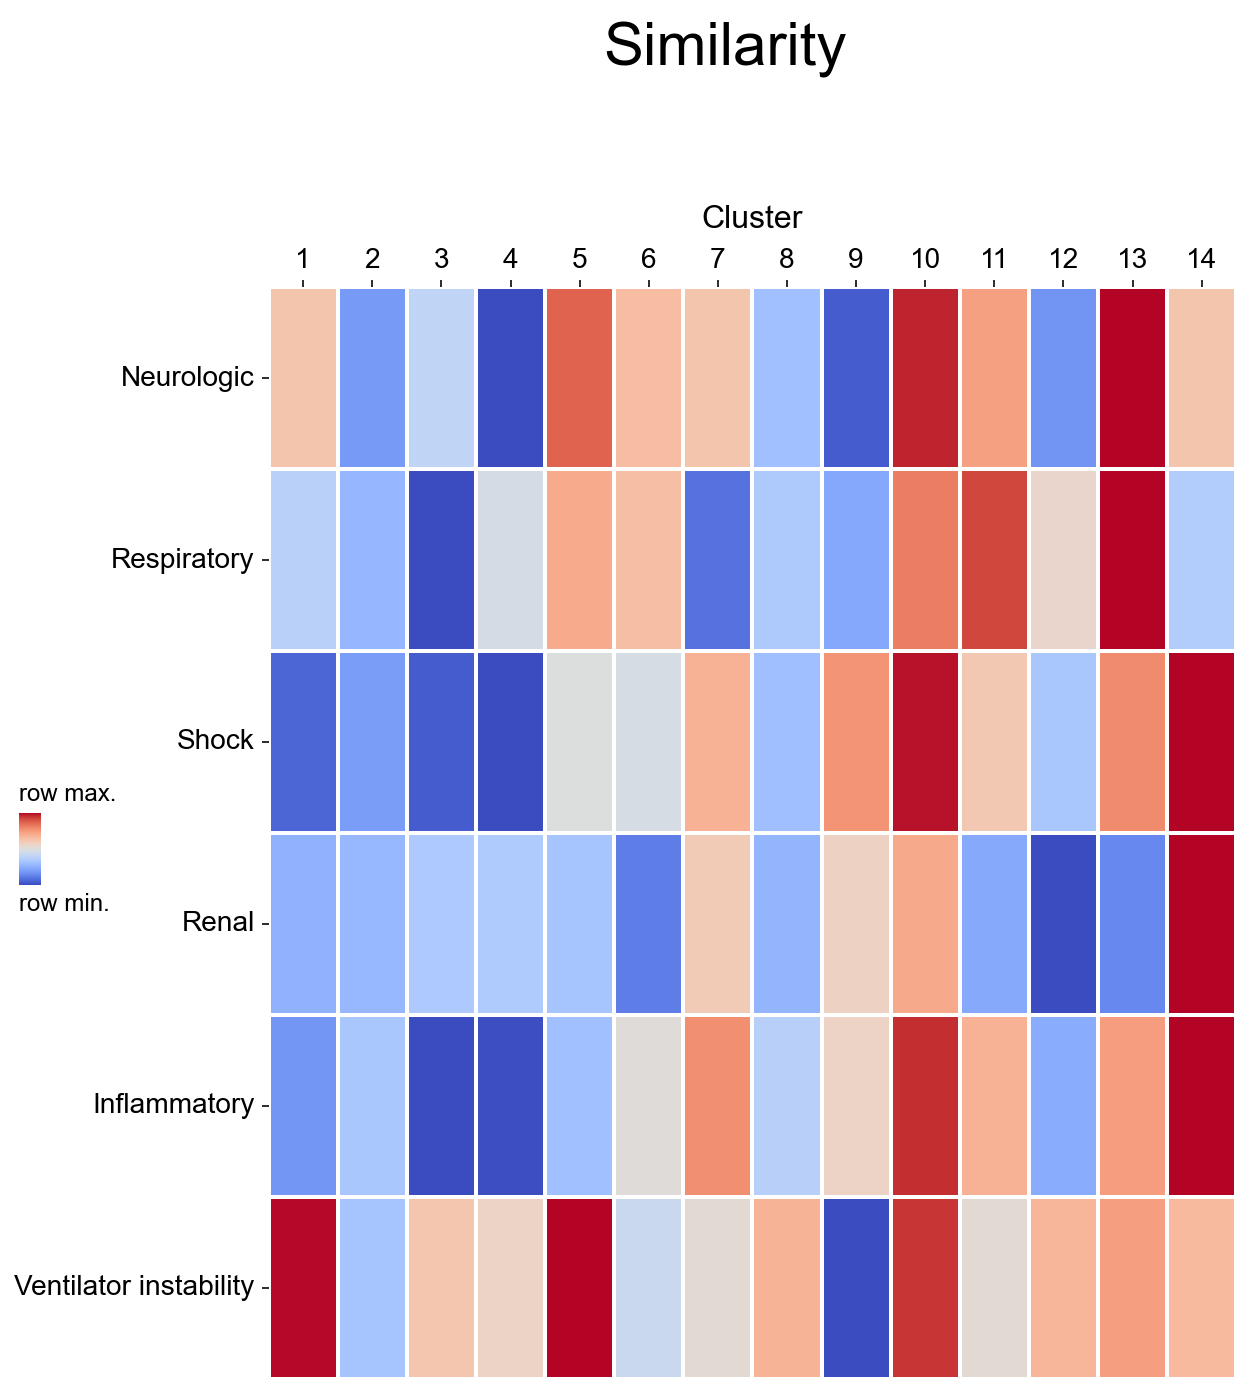

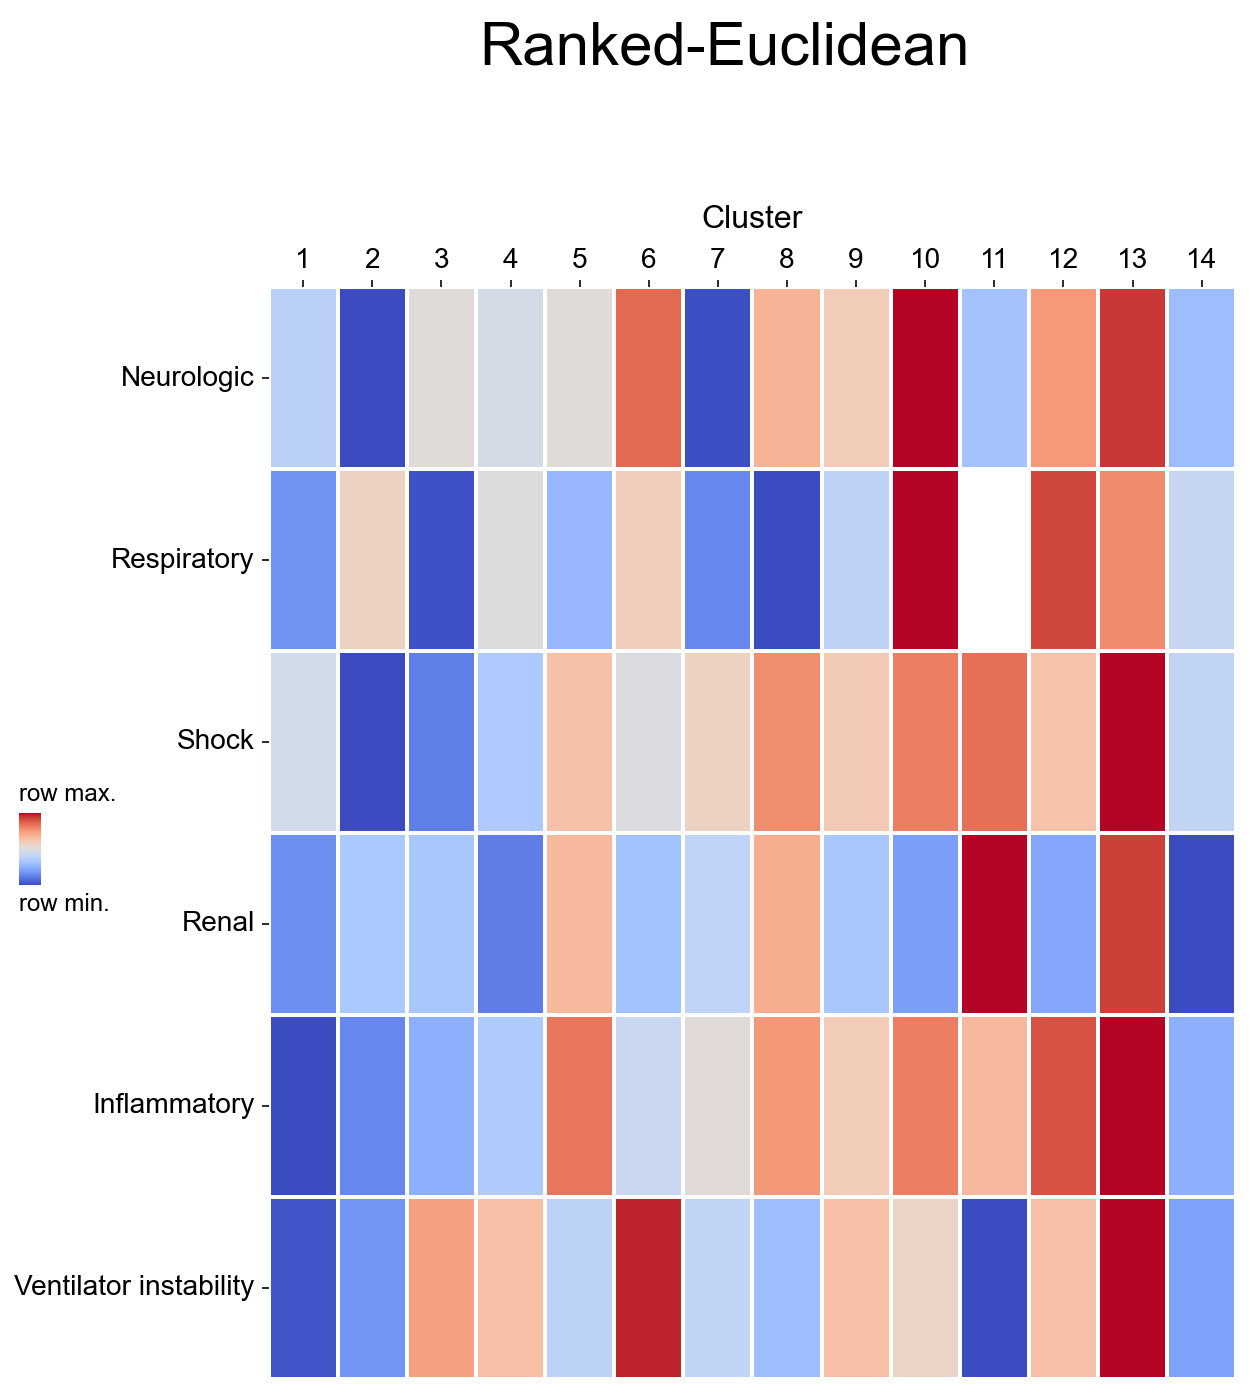

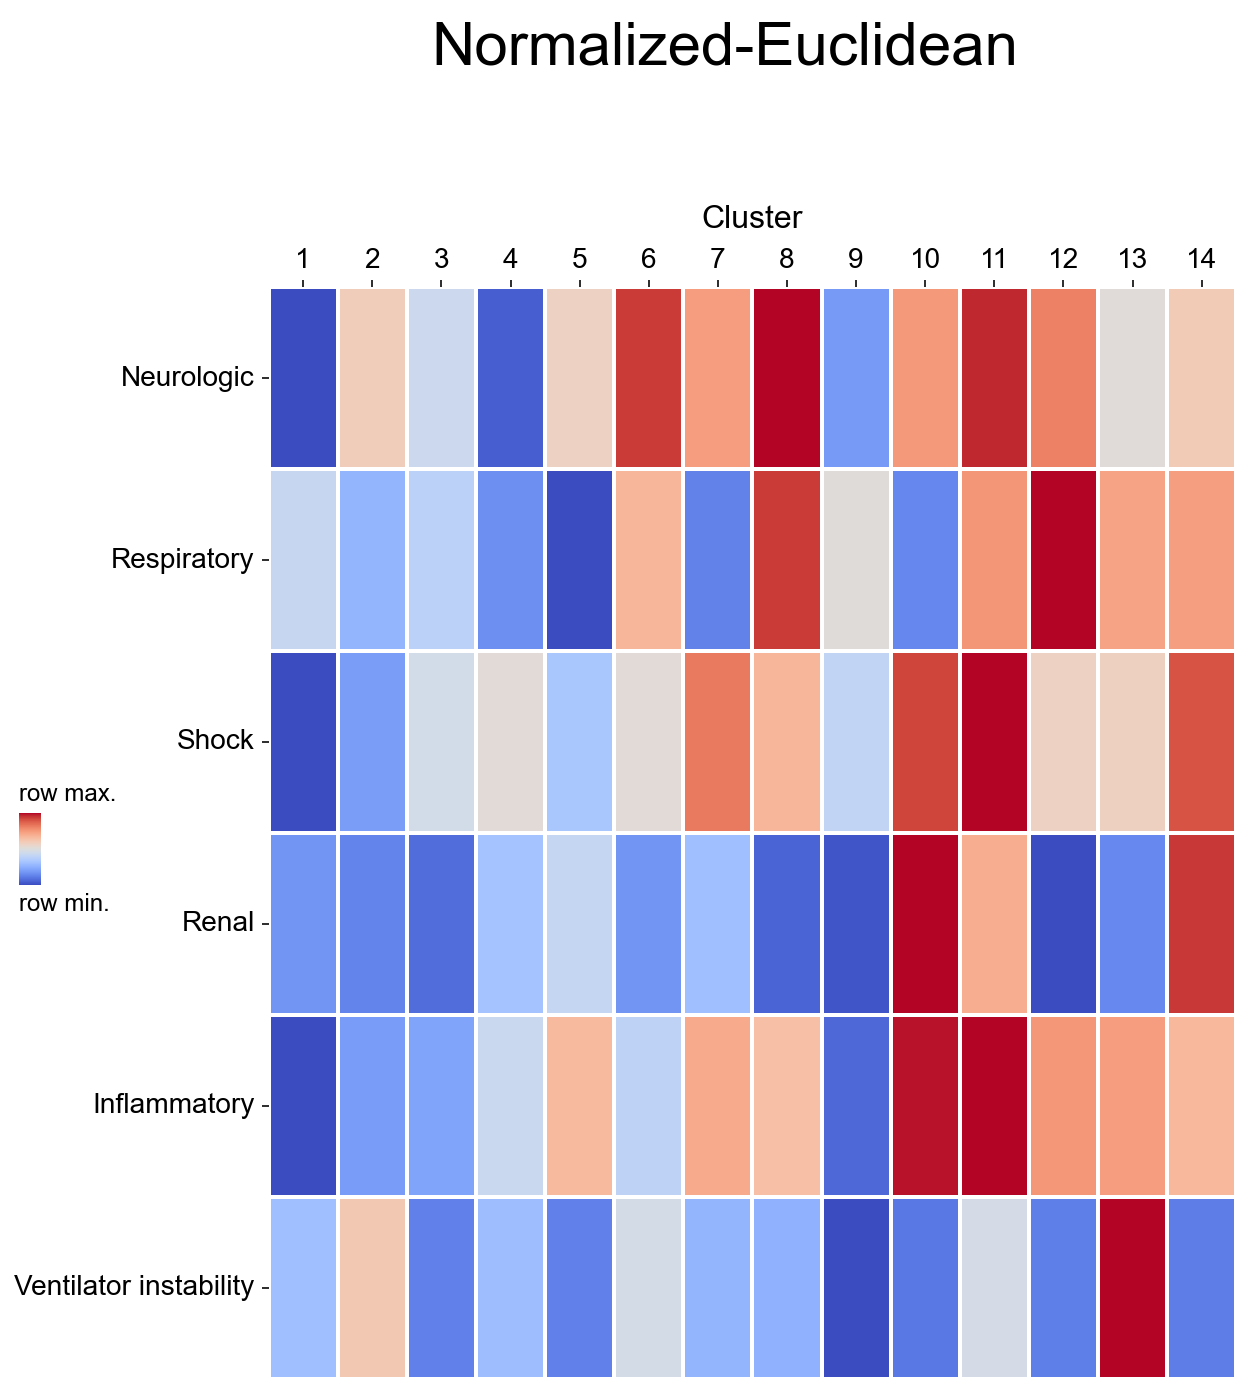

In [36]:
%%time    

for key in approaches.keys():
    
    clustering.quilt(
    data_with_mortality=data,
    data_mtx=approaches[key]['feature_matrix'],
    assignment=approaches[key]['assignments'][14]
        )

    plt.suptitle(f'{key}',fontsize=30, )
        
    dump_figure(
    f'quilt-{key}.pdf')
    

CPU times: user 3.11 s, sys: 177 ms, total: 3.29 s
Wall time: 6.84 s


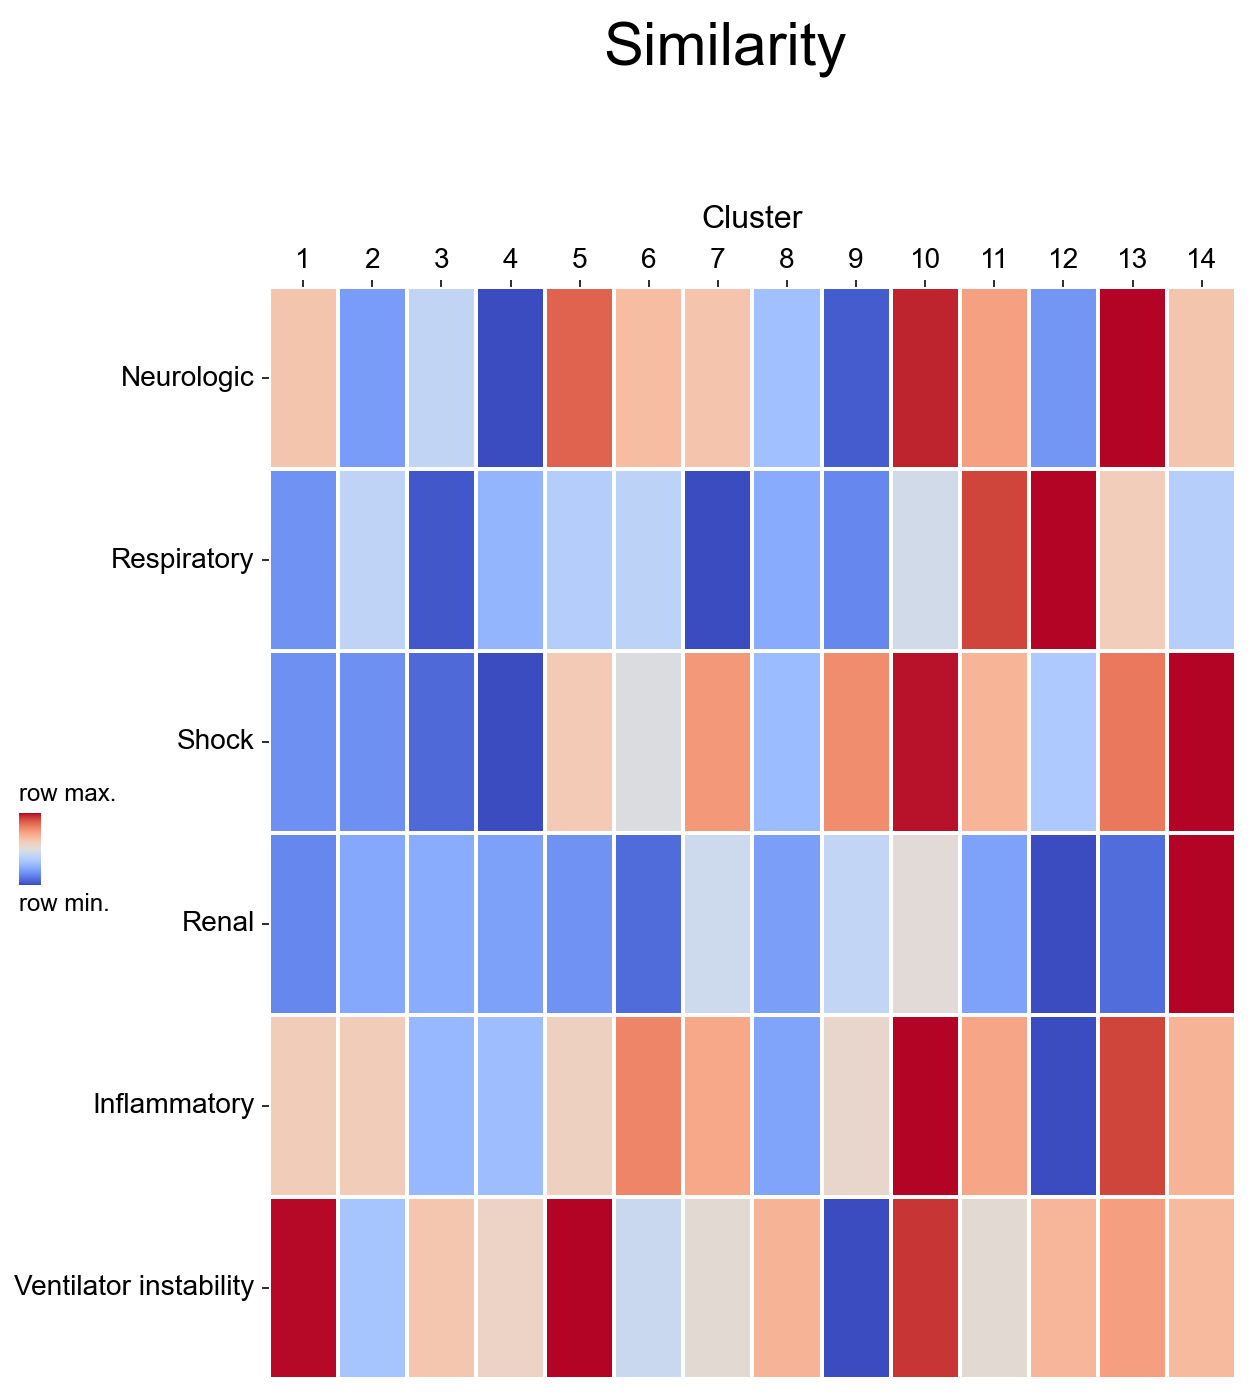

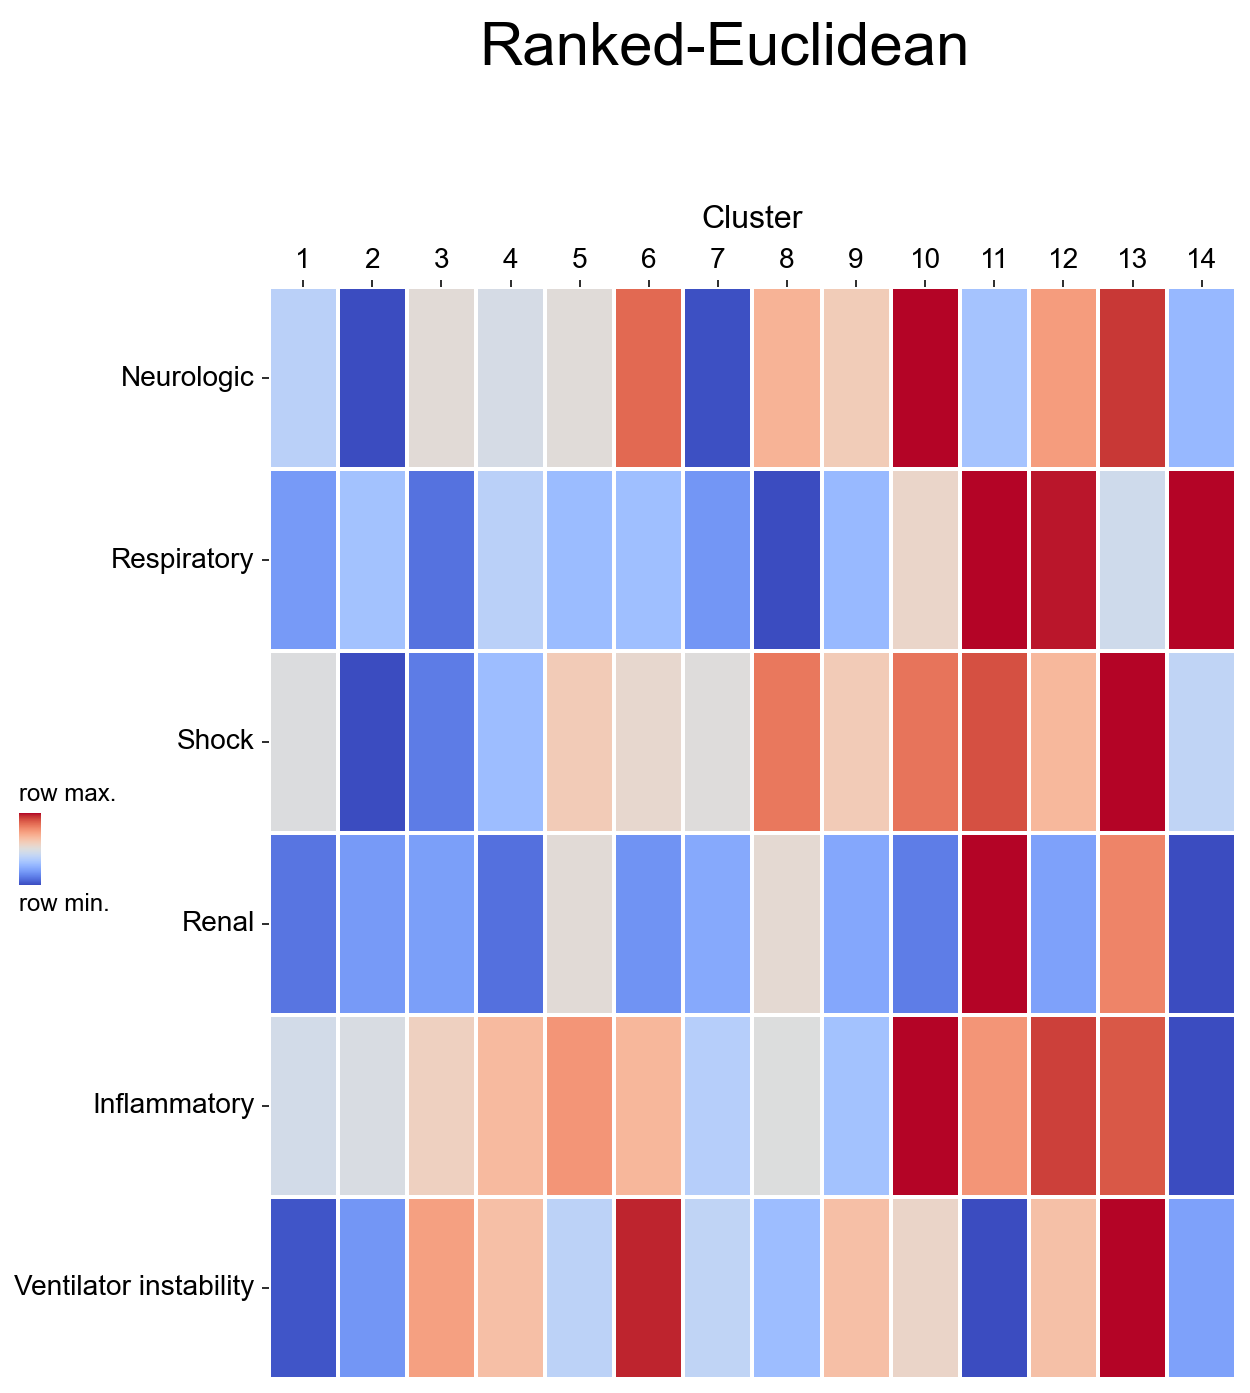

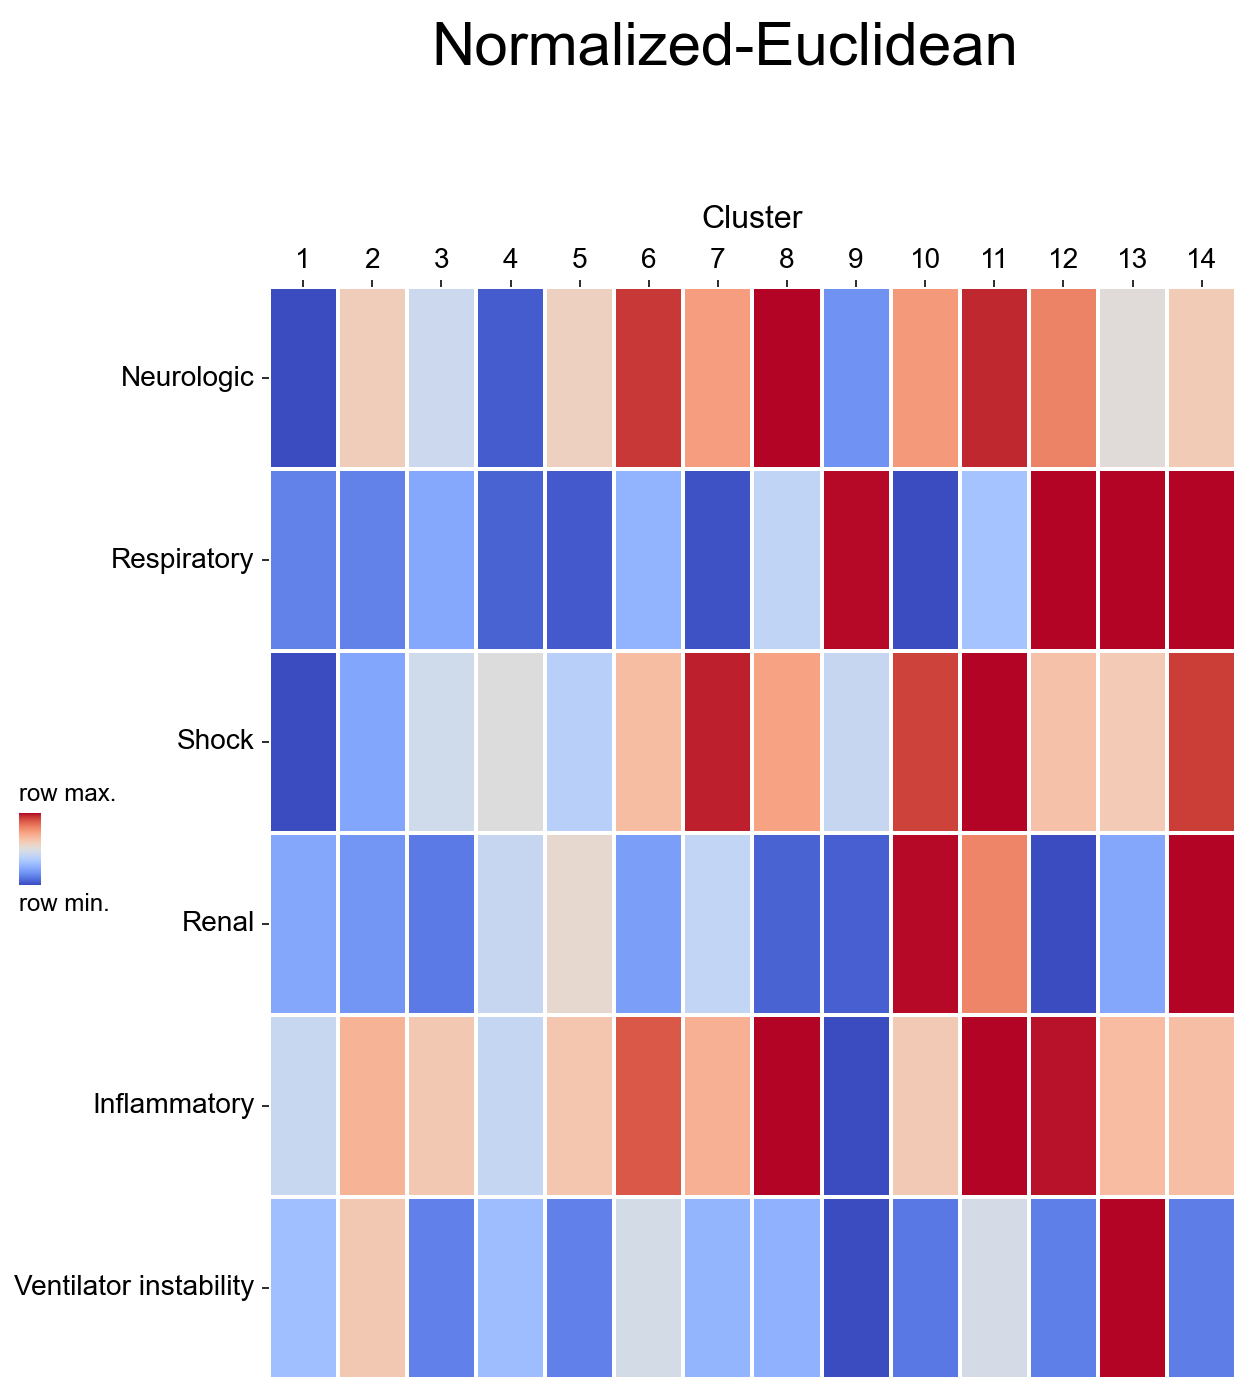

In [37]:
%%time    

for key in approaches.keys():
    
    clustering.quilt2(
    data_with_mortality=data,
    data_mtx=approaches[key]['feature_matrix'],
    assignment=approaches[key]['assignments'][14]
        )

    plt.suptitle(f'{key}',fontsize=30, )
        
    dump_figure(
    f'quilt2-{key}.pdf')
    

CPU times: user 3.84 s, sys: 324 ms, total: 4.16 s
Wall time: 7.47 s


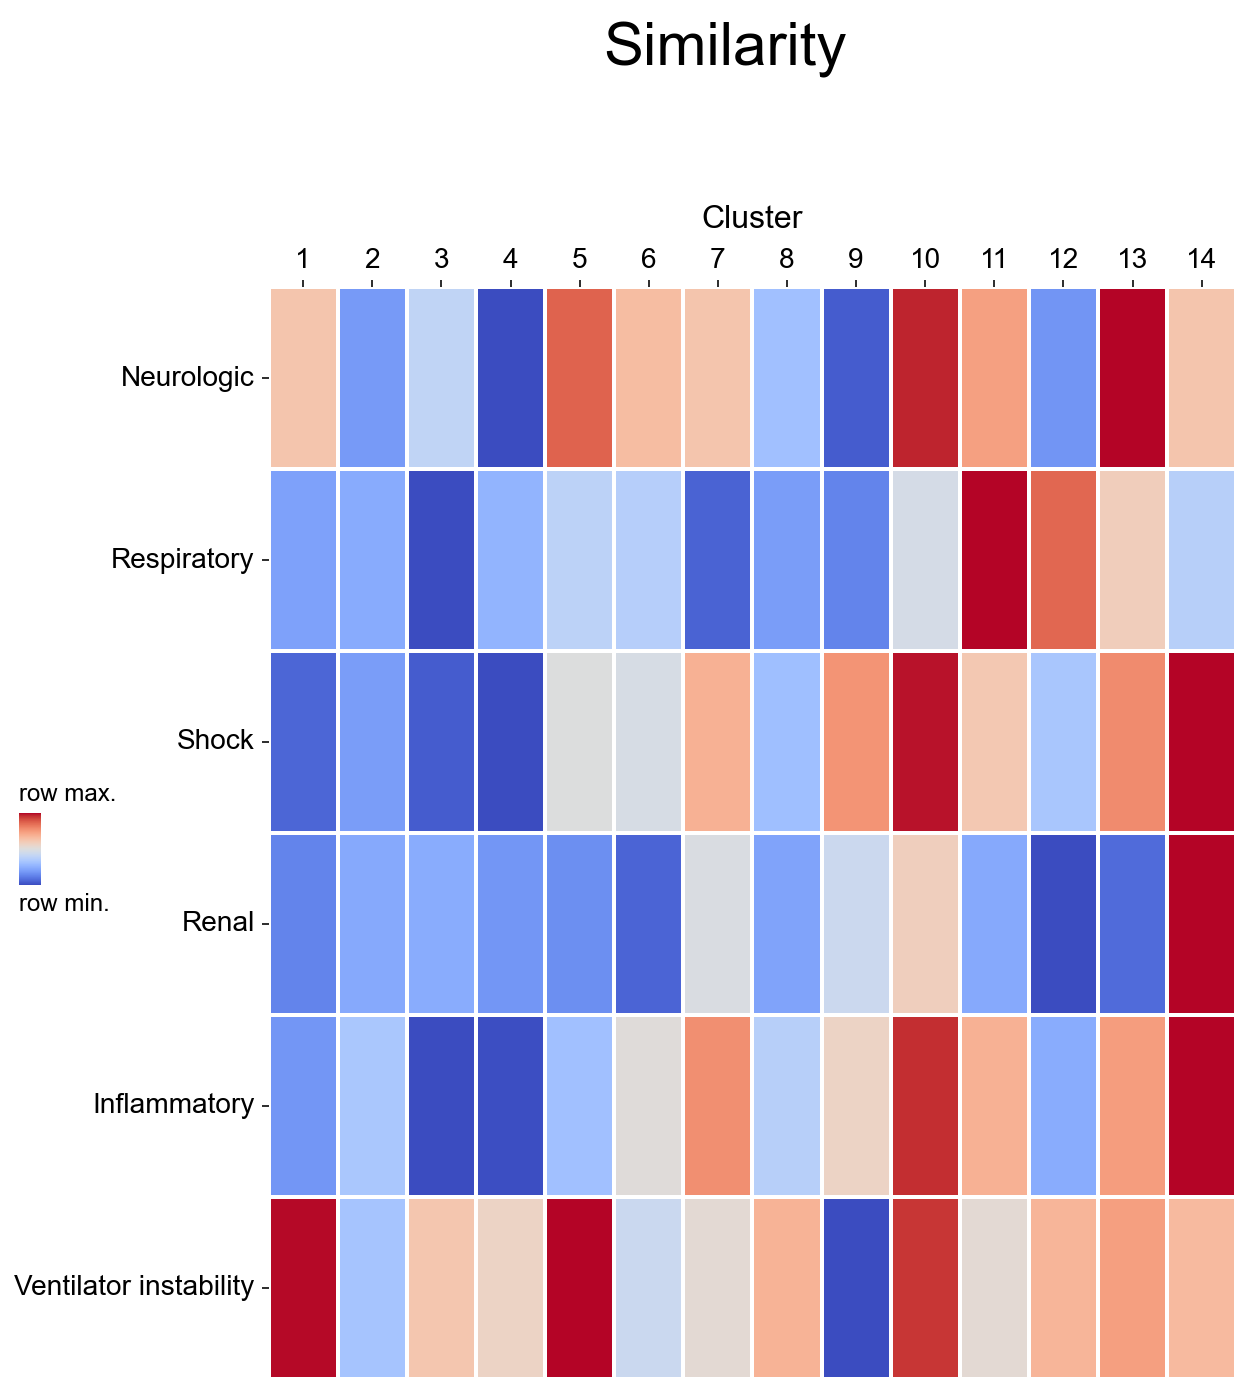

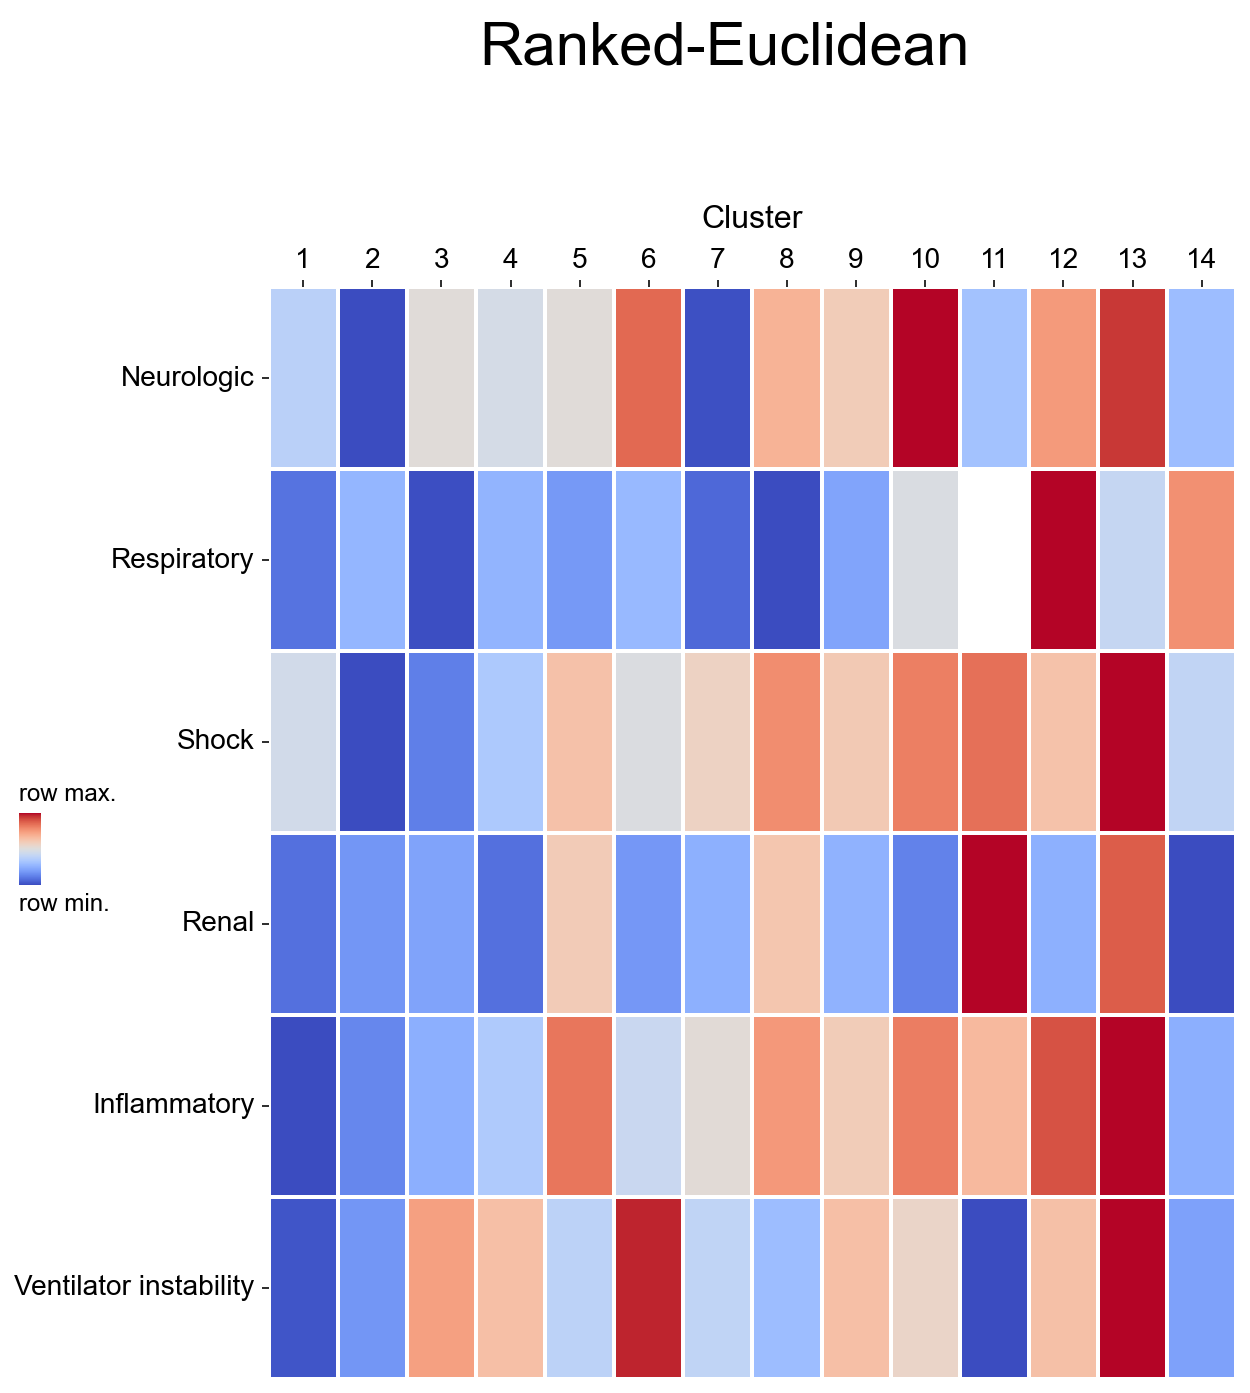

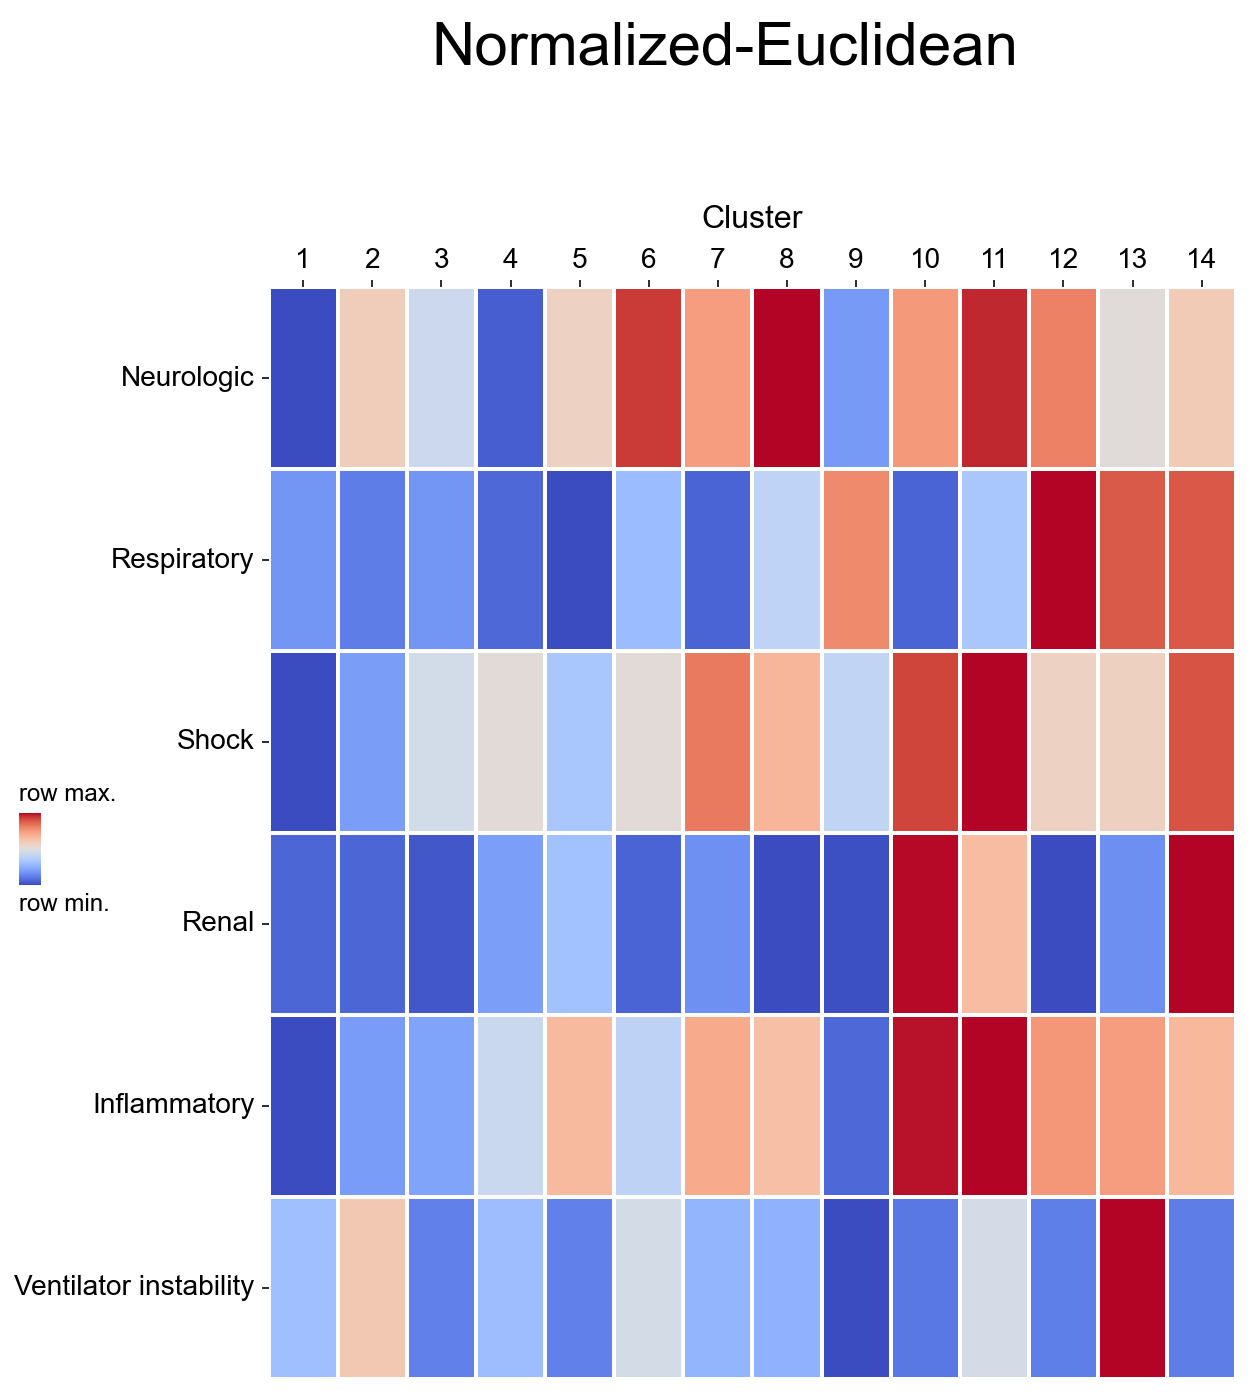

In [38]:
%%time    

for key in approaches.keys():
    
    clustering.quilt3(
    data_with_mortality=data,
    data_mtx=approaches[key]['feature_matrix'],
    assignment=approaches[key]['assignments'][14]
        )

    plt.suptitle(f'{key}',fontsize=30, )
        
    dump_figure(
    f'quilt3-{key}.pdf')
    

CPU times: user 2.91 s, sys: 202 ms, total: 3.11 s
Wall time: 5.3 s


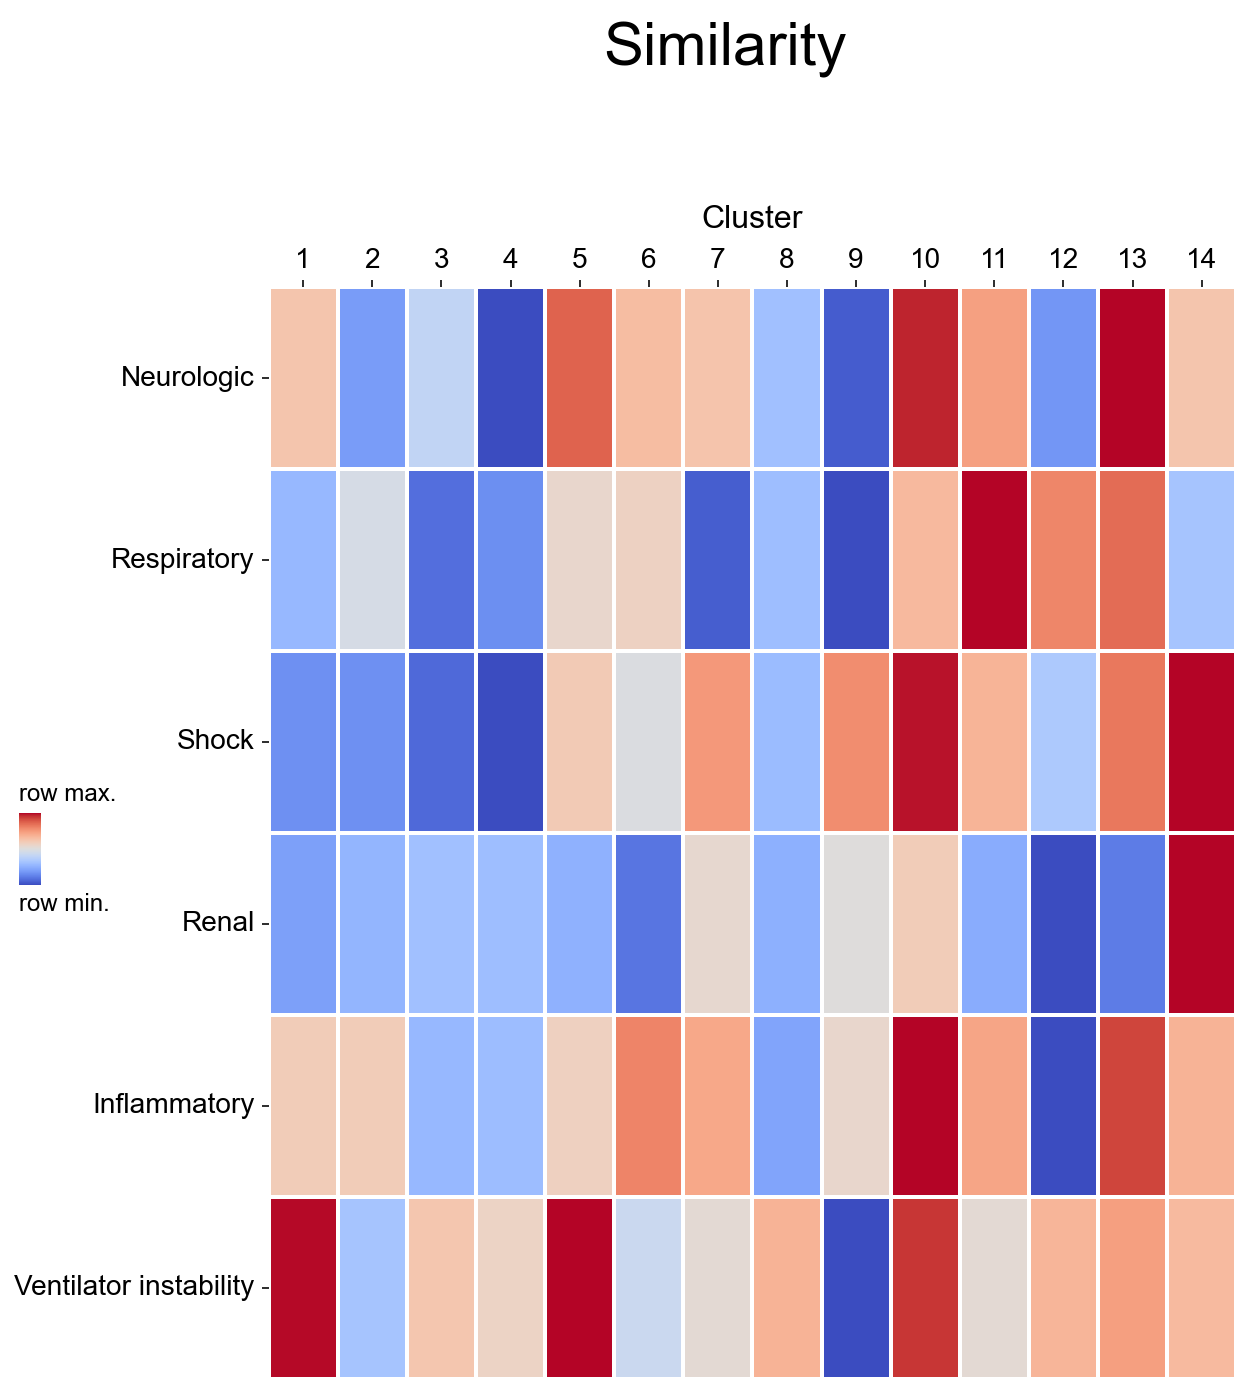

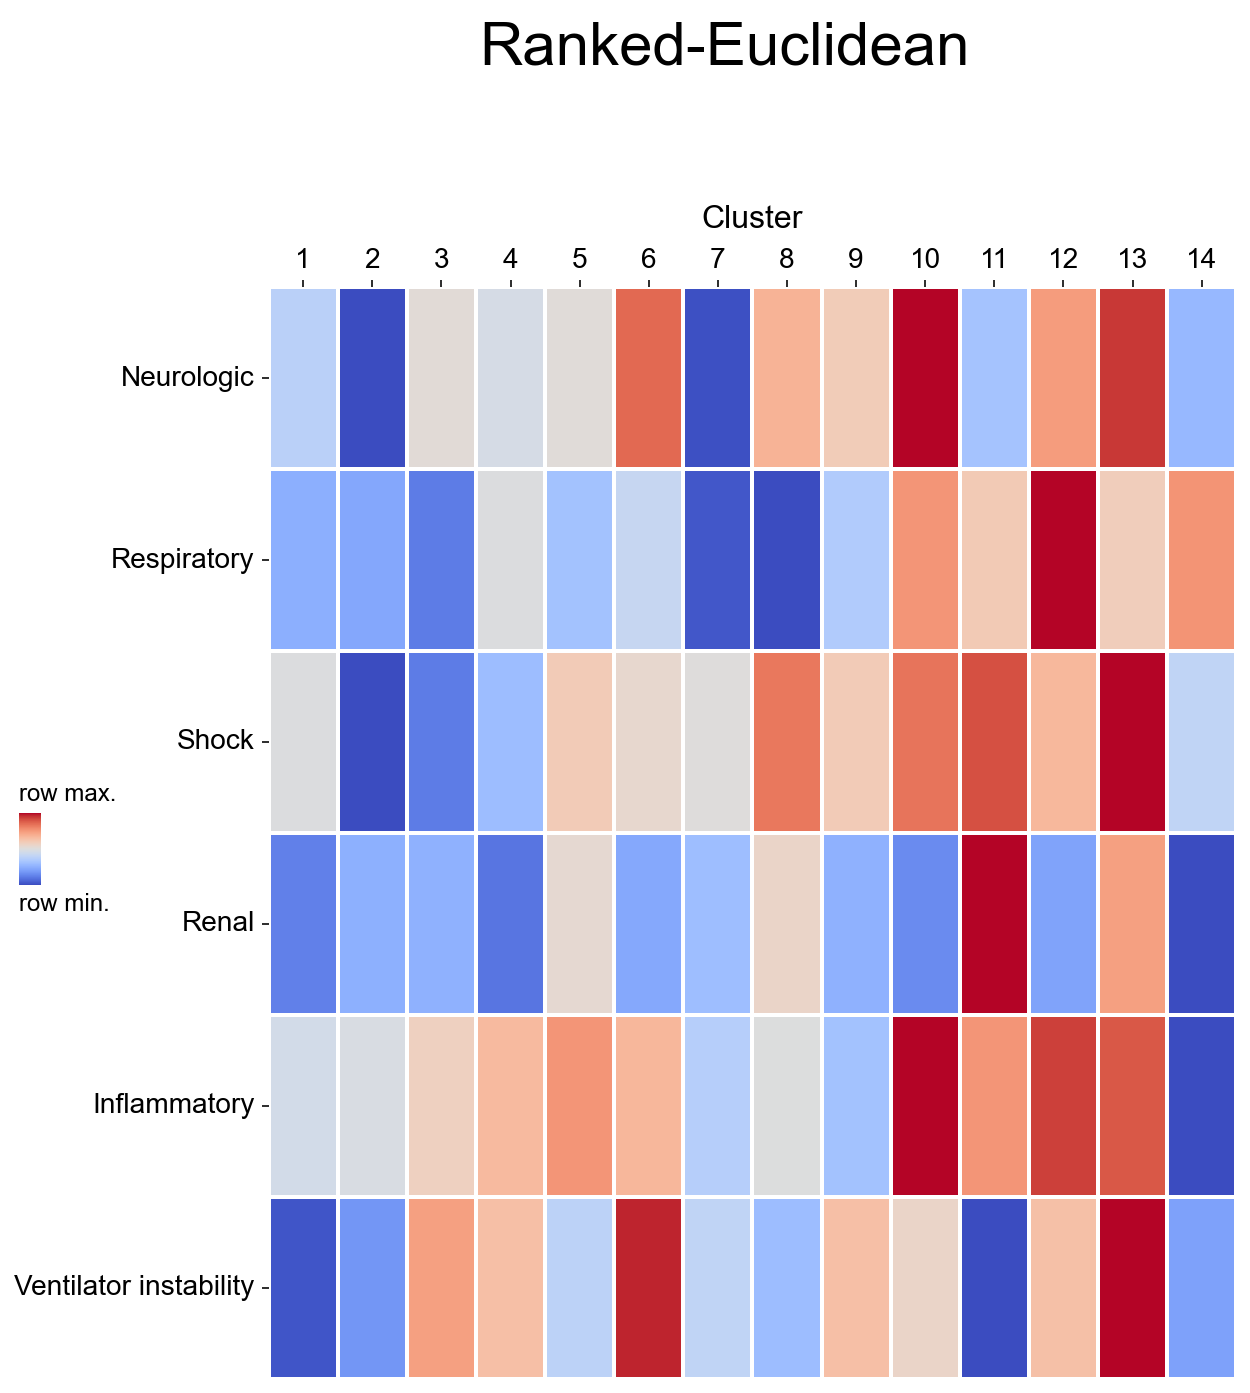

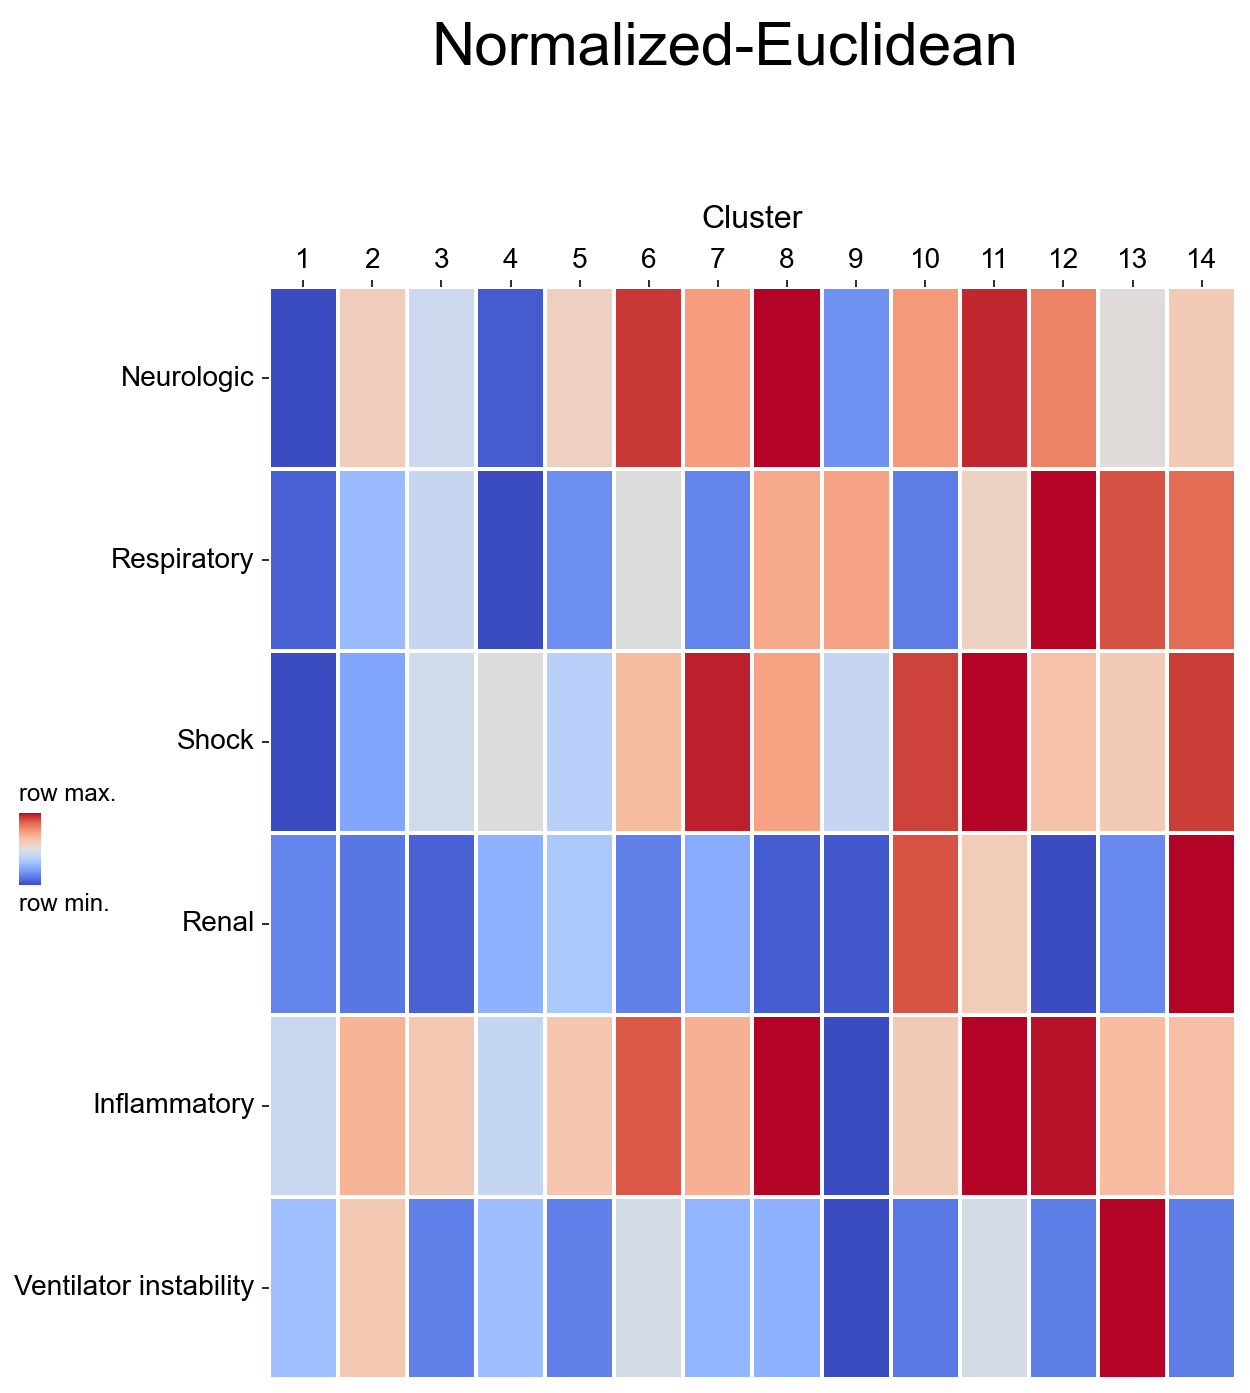

In [39]:
%%time    

for key in approaches.keys():
    
    clustering.quilt4(
    data_with_mortality=data,
    data_mtx=approaches[key]['feature_matrix'],
    assignment=approaches[key]['assignments'][14]
        )

    plt.suptitle(f'{key}',fontsize=30, )
        
    dump_figure(
    f'quilt4-{key}.pdf')
    